## 1. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

pd.set_option('max.columns', 100)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy import stats

## 2. 데이터 불러오기

In [2]:
# 데이터 확인
raw_data = pd.read_csv('train.csv')

print('Shape of Data :', raw_data.shape, '\n')
print('-' * 50)
print(raw_data.info())

Shape of Data : (1460, 81) 

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1

## 3. 결측치 처리

In [3]:
object_list = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'PoolQC', 'Fence', 'MiscFeature']

# 원래 데이터를 보존하기 위해 새로운 DataFrame 생성
modify_data = raw_data.copy()

# 결측치를 의미하지 않는 값에 'No have' 채워넣기
for feature in object_list:
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *Before Modify* :'.format(feature), null_data, '\n')
    
    modify_data.loc[modify_data[feature].isnull(), feature] = 'No have'
    
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *After Modify* :'.format(feature), null_data)
    print('-' * 60)

Number of null values of Alley *Before Modify* : 1369 

Number of null values of Alley *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtQual *Before Modify* : 37 

Number of null values of BsmtQual *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtCond *Before Modify* : 37 

Number of null values of BsmtCond *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtExposure *Before Modify* : 38 

Number of null values of BsmtExposure *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType1 *Before Modify* : 37 

Number of null values of BsmtFinType1 *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType2 *Before Modify* : 38 

Number of null values of BsmtFinType2 *After Modify* : 0
---------------

In [4]:
print('Number of null values of GarageYrBlt *Before Modify* :', modify_data['GarageYrBlt'].isnull().sum(), '\n')

# 결측치 대체
modify_data.loc[modify_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0
print('Number of null values of GarageYrBlt *After Modify* :', modify_data['GarageYrBlt'].isnull().sum())

Number of null values of GarageYrBlt *Before Modify* : 81 

Number of null values of GarageYrBlt *After Modify* : 0


In [5]:
print('Number of null values of MasVnrType *Before* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *Before* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *Before* :', modify_data['Electrical'].isnull().sum(), '\n')

modify_data['MasVnrType'].fillna('None', inplace = True)
modify_data['MasVnrArea'].fillna(0, inplace = True)
modify_data['Electrical'].fillna(modify_data['Electrical'].mode()[0], inplace = True)

print('Number of null values of MasVnrType *After* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *After* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *After* :', modify_data['Electrical'].isnull().sum())

Number of null values of MasVnrType *Before* : 8 

Number of null values of MasVnrArea *Before* : 8 

Number of null values of Electrical *Before* : 1 

Number of null values of MasVnrType *After* : 0 

Number of null values of MasVnrArea *After* : 0 

Number of null values of Electrical *After* : 0


In [6]:
# 'LotFrontage' 변수의 결측치를 예측하기 위한 변수 추출
miss_list = ['Id', 'MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', '1stFlrSF', 
             'BldgType', 'GrLivArea', 'LotArea', 'LotFrontage']

# 데이터 추출
miss_data = modify_data[miss_list]

print('Shape of miss_data :', miss_data.shape)
miss_data.head()

Shape of miss_data : (1460, 10)


,Id,MSSubClass,MSZoning,LotShape,LotConfig,1stFlrSF,BldgType,GrLivArea,LotArea,LotFrontage
0,1,60,RL,Reg,Inside,856,1Fam,1710,8450,65.0
1,2,20,RL,Reg,FR2,1262,1Fam,1262,9600,80.0
2,3,60,RL,IR1,Inside,920,1Fam,1786,11250,68.0
3,4,70,RL,IR1,Corner,961,1Fam,1717,9550,60.0
4,5,60,RL,IR1,FR2,1145,1Fam,2198,14260,84.0


In [7]:
outlier_id = miss_data[miss_data['LotFrontage'] > 300]['Id']

# 'LotFrontage' 변수의 값이 300 넘는 관측치 삭제
miss_data = miss_data[~miss_data['Id'].isin(outlier_id)]
miss_data.reset_index(drop = True, inplace = True)

# 'NewLotShape' 변수 생성
print('Shape of miss_data *Before Create* :', miss_data.shape, '\n')

miss_data['NewLotShape'] = np.nan

for index in miss_data.index:
    
    if miss_data.loc[index, 'LotShape'] == 'Reg':
        miss_data.loc[index, 'NewLotShape'] = 'Reg'
        
    else:
        miss_data.loc[index, 'NewLotShape'] = 'Irreg'
        
print('Shape of miss_data *After Create* :', miss_data.shape, '\n')
print('Unique value of NewLotShape :', miss_data['NewLotShape'].unique())

Shape of miss_data *Before Create* : (1458, 10) 

Shape of miss_data *After Create* : (1458, 11) 

Unique value of NewLotShape : ['Reg' 'Irreg']


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

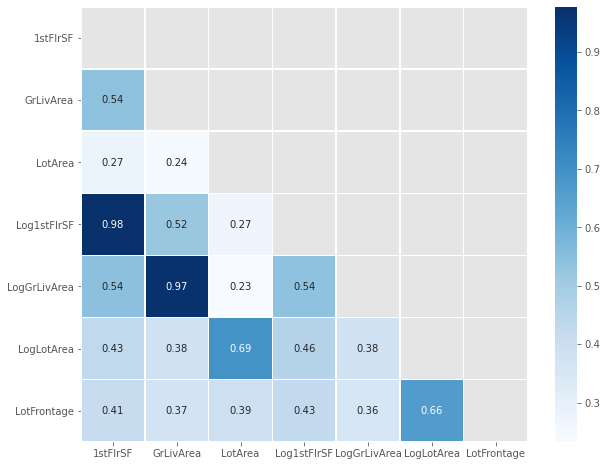

In [8]:
# 연속형 변수를 로그화
miss_data['Log1stFlrSF'] = miss_data['1stFlrSF'].apply(lambda x: np.log1p(x))
miss_data['LogGrLivArea'] = miss_data['GrLivArea'].apply(lambda x: np.log1p(x))
miss_data['LogLotArea'] = miss_data['LotArea'].apply(lambda x: np.log1p(x))

# 로그화 수행 뒤 Heatmap
corr_data = miss_data[['1stFlrSF', 'GrLivArea', 'LotArea', 'Log1stFlrSF',
                       'LogGrLivArea', 'LogLotArea', 'LotFrontage']].corr()

# 'mask' 옵션 설정
mask = np.zeros_like(corr_data, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 시각화 과정
plt.figure(figsize = (10, 8))

sns.heatmap(corr_data, mask = mask, cmap = 'Blues', linewidth = 0.5, annot = True, fmt = ".2f")

In [9]:
# 결측치를 없애기 위해 사용하고자 하는 변수 추출
value_list = ['Id', 'MSSubClass', 'MSZoning', 'NewLotShape', 'LotConfig', 'BldgType',
             'Log1stFlrSF', 'GrLivArea', 'LogLotArea', 'LotFrontage']

pre_miss_data = miss_data[~miss_data['LotFrontage'].isnull()][value_list]
print('Shape of pre_miss_data :', pre_miss_data.shape)

# 'MSSubClass' 변수 문자형 타입으로 변환
pre_miss_data['MSSubClass'] = pre_miss_data['MSSubClass'].astype('str')

pre_miss_data.head()

Shape of pre_miss_data : (1199, 10)


,Id,MSSubClass,MSZoning,NewLotShape,LotConfig,BldgType,Log1stFlrSF,GrLivArea,LogLotArea,LotFrontage
0,1,60,RL,Reg,Inside,1Fam,6.753438,1710,9.042040,65.0
1,2,20,RL,Reg,FR2,1Fam,7.141245,1262,9.169623,80.0
2,3,60,RL,Irreg,Inside,1Fam,6.825460,1786,9.328212,68.0
3,4,70,RL,Irreg,Corner,1Fam,6.869014,1717,9.164401,60.0
4,5,60,RL,Irreg,FR2,1Fam,7.044033,2198,9.565284,84.0


In [10]:
# RandomFroestRegressor 수행
data = pd.get_dummies(pre_miss_data, drop_first = True)

X = data.drop(['Id', 'LotFrontage'], axis = 1)
y = data['LotFrontage']

rf_model = RandomForestRegressor(random_state = 1025).fit(X, y)

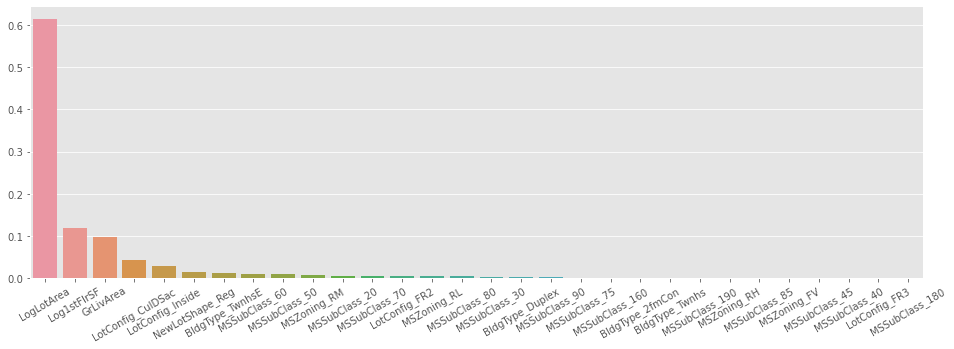

In [11]:
# 변수의 중요도 시각화
feature_data = pd.DataFrame(rf_model.feature_importances_, index = X.columns, columns = ['Importance'])

plt.figure(figsize = (16, 5))

plot_data = feature_data.sort_values(by = 'Importance', ascending = False)

sns.barplot(x = plot_data.index, y = 'Importance', data = plot_data)
plt.xticks(rotation = 30)
plt.ylabel('')
plt.show()

- LogLotArea가 가장 높은 중요도를 나타내기 때문에 LogLotArea로 결측치를 채워주자.
- 이때 채워주기 위해서 knnimputer를 사용하도록 하자.

In [12]:
# 'LotFrontage' 결측치를 대체해주는 함수 만들기
def imputer_lotfrontage(raw_data):
    
    print('Number of null values of LotFrontage *Before Modify* :', raw_data['LotFrontage'].isnull().sum(), '\n')
    
    # 'KNNImputer' 라이브러리 불러오기
    from sklearn.impute import KNNImputer
    
    # 'LotFrontage' 변수에 결측치를 가지는 'Id' 추출 후 저장
    miss_id = raw_data[raw_data['LotFrontage'].isnull()]['Id'].unique()
    
    # 'Id', 'LotFrontage', 'LotArea' 변수 추출 후 저장
    data = raw_data[['Id', 'LotFrontage', 'LotArea']]
    
    # 'LotFrontage' 변수의 값이 300 넘는 관측치를 삭제하기로 했으므로 삭제
    outlier_id = data[data['LotFrontage'] > 300]['Id']
    data = data[~data['Id'].isin(outlier_id)]
    
    # 'Id' 변수를 인덱스로 지정
    data = data.set_index('Id')
    
    # 'LotArea' 변수를 로그화 수행 후, 변수 삭제
    data['LotLogArea'] = data['LotArea'].apply(lambda x: np.log(x))
    data = data.drop('LotArea', axis = 1)
    
    # 모델 객체 생성 후 학습시키고 DataFrame으로 저장
    # 원본 데이터에 결측치로 기입되어 있는 관측치들만 수정해주기 위해 DataFrame을 만들 때, 인덱스를 위 데이터의 인덱스로 지정
    imputer = KNNImputer(n_neighbors = 5)
    pre_data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns, index = data.index)
    
    # 결측치가 존재하던 관측치만 저장
    pre_data = pre_data[pre_data.index.isin(miss_id)]
    
    # 원본 데이터 결측치를 대입해주는 과정
    for id_value, lot_value in zip(pre_data.index, pre_data['LotFrontage']):
        for index in raw_data.index:
            
            if raw_data.loc[index, 'Id'] == id_value:
                raw_data.loc[index, 'LotFrontage'] = lot_value
    
    print('Number of null values of LotFrontage *After Modify* :', raw_data['LotFrontage'].isnull().sum())
 
    return raw_data

In [13]:
# 생성한 함수 적용
modify_data = imputer_lotfrontage(modify_data)

Number of null values of LotFrontage *Before Modify* : 259 

Number of null values of LotFrontage *After Modify* : 0


- knnimputer를 이용하여 모든 결측치를 처리해 주었다.

In [14]:
# 순서형 변수 중 문자열 타입으로 되어있는 변수를 변환
# 'ExterQual' & 'ExterCond'
mapping = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1}

modify_data['ExterQual'] = modify_data['ExterQual'].map(mapping)
modify_data['ExterCond'] = modify_data['ExterCond'].map(mapping)

# 'BsmtQual' & 'BsmtCond'
mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['BsmtQual'] = modify_data['BsmtQual'].map(mapping)
modify_data['BsmtCond'] = modify_data['BsmtCond'].map(mapping)

# 'HeatingQC'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['HeatingQC'] = modify_data['HeatingQC'].map(mapping)

# 'KitchenQual'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['KitchenQual'] = modify_data['KitchenQual'].map(mapping)

# 'FireplaceQu'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['FireplaceQu'] = modify_data['FireplaceQu'].map(mapping)

# 'GarageQual' & 'GarageCond'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['GarageQual'] = modify_data['GarageQual'].map(mapping)
modify_data['GarageCond'] = modify_data['GarageCond'].map(mapping)

# 'PoolQC'
mapping = mapping = {'No have' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4}

modify_data['PoolQC'] = modify_data['PoolQC'].map(mapping)

In [15]:
print('Number of incorrectly entered value *Wd Shng* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Wd Shng']), '\n')

print('Number of incorrectly entered value *CmentBd* :',
      len(modify_data[modify_data['Exterior2nd'] == 'CmentBd']), '\n')

print('Number of incorrectly entered value *Brk Cmn* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Brk Cmn']))

Number of incorrectly entered value *Wd Shng* : 38 

Number of incorrectly entered value *CmentBd* : 60 

Number of incorrectly entered value *Brk Cmn* : 7


In [16]:
modify_data.loc[modify_data['Exterior2nd'] == 'Wd Shng', 'Exterior2nd'] = 'Wd Sdng'
modify_data.loc[modify_data['Exterior2nd'] == 'CmentBd', 'Exterior2nd'] = 'CemntBd'
modify_data.loc[modify_data['Exterior2nd'] == 'Brk Cmn', 'Exterior2nd'] = 'BrkComm'

print('Number of incorrectly entered value *Wd Shng* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Wd Shng']), '\n')

print('Number of incorrectly entered value *CmentBd* :',
      len(modify_data[modify_data['Exterior2nd'] == 'CmentBd']), '\n')

print('Number of incorrectly entered value *Brk Cmn* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Brk Cmn']))

Number of incorrectly entered value *Wd Shng* : 0 

Number of incorrectly entered value *CmentBd* : 0 

Number of incorrectly entered value *Brk Cmn* : 0


- 모든 결측치를 제거해 주었다.
- 이젠 변수를 살펴보며 의미있는 변수들을 만들어 주자.

In [17]:
# 결측치 제거한 데이터를 final_data로 바꿔주자.
final_data = modify_data.copy()

In [18]:
print('Shape of final_data *Before Create* :', final_data.shape, '\n')

# 'NewCondition1' 변수 생성
final_data['NewCondition1'] = np.nan

for index in final_data.index:
    
    value = final_data.loc[index, 'Condition1']
    
    if (value == 'Artery') | (value == 'Feedr'):
        final_data.loc[index, 'NewCondition1'] = 'Street'
        
    elif (value == 'PosN') | (value == 'PosA'):
        final_data.loc[index, 'NewCondition1'] = 'Positive'
        
    elif value == 'Norm':
        final_data.loc[index, 'NewCondition1'] = 'Norm'
        
    else:
        final_data.loc[index, 'NewCondition1'] = 'Rail'
        
print('Unique values of NewCondition1 :', final_data['NewCondition1'].unique(), '\n')

# 'CountCon' 변수 생성
final_data['CountCon'] = np.nan

for index in final_data.index:
    
    first_value = modify_data.loc[index, 'Condition1']
    second_value = modify_data.loc[index, 'Condition2']
    
    # 'Condition1'과 'Condition2' 변수 모두 'Norm'인 경우
    if (first_value == 'Norm') & (second_value == 'Norm'):
        final_data.loc[index, 'CountCon'] = 0
    
    else:
        final_data.loc[index, 'CountCon'] = 1

print('Unique values of CountCon :', final_data['CountCon'].unique(), '\n')
print('Shape of final_data *After Create* :', final_data.shape)

Shape of final_data *Before Create* : (1460, 81) 

Unique values of NewCondition1 : ['Norm' 'Street' 'Positive' 'Rail'] 

Unique values of CountCon : [0. 1.] 

Shape of final_data *After Create* : (1460, 83)


In [19]:
# 'SameExterior' 변수 생성
print('Shape of final_data *Before Create* :', final_data.shape, '\n')

final_data['SameExterior'] = np.nan

for index in final_data.index:
    
    first_exterior = final_data.loc[index, 'Exterior1st']
    second_exterior = final_data.loc[index, 'Exterior2nd']
    
    if first_exterior == second_exterior:
        final_data.loc[index, 'SameExterior'] = 1
    
    else:
        final_data.loc[index, 'SameExterior'] = 0
        
print('Shape of final_data *After Create* :', final_data.shape, '\n')
print('Unique vlaues of SameExterior :', final_data['SameExterior'].unique())

Shape of final_data *Before Create* : (1460, 83) 

Shape of final_data *After Create* : (1460, 84) 

Unique vlaues of SameExterior : [1. 0.]


In [20]:
# 데이터를 쉽게 사용하기 위해서 final_data를 train으로 바꿔주자.
train = final_data.copy()

In [21]:
train.MSSubClass=train.MSSubClass.astype('object')

mapping = {'No have':0,'No':1, 'Mn':2, 'Av':3, 'Gd':4}
train['BsmtExposure'] = train['BsmtExposure'].map(mapping)
mapping = {'No have':0,'LwQ':1, 'Rec':2,'BLQ':3,'ALQ':4,'Unf':5,'GLQ':6}
train['BsmtFinType1'] = train['BsmtFinType1'].map(mapping)
train['BsmtFinType2'] = train['BsmtFinType2'].map(mapping)
mapping = {'Y':1, 'N':0}
train['CentralAir'] = train['CentralAir'].map(mapping)
mapping = {'No have':0,'Unf':1, 'RFn':2, 'Fin':3}
train['GarageFinish'] = train['GarageFinish'].map(mapping)
mapping = {'N':0,'P':1,'Y':2}
train['PavedDrive'] = train['PavedDrive'].map(mapping)
mapping = {'No have':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
train['Fence'] = train['Fence'].map(mapping)

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


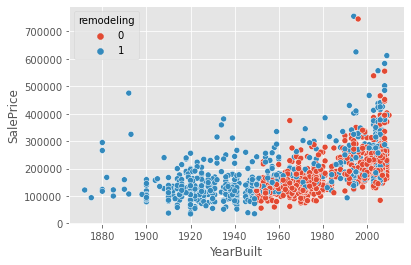

In [22]:
# YearRemodAdd와 YearBuilt를 이용하여 remodeling의 여부를 파악해보자.
train['remodeling'] = 0
for i in train.index:
    if train.loc[i,'YearBuilt'] == train.loc[i,'YearRemodAdd']:
        train.loc[i,'remodeling'] = 0
    else:
        train.loc[i,'remodeling'] = 1

# 1940년도에 지어진 건물은 거의다 remodeling을 했다.
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', hue = 'remodeling')

Text(0.5, 1.0, 'non remodeling')

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


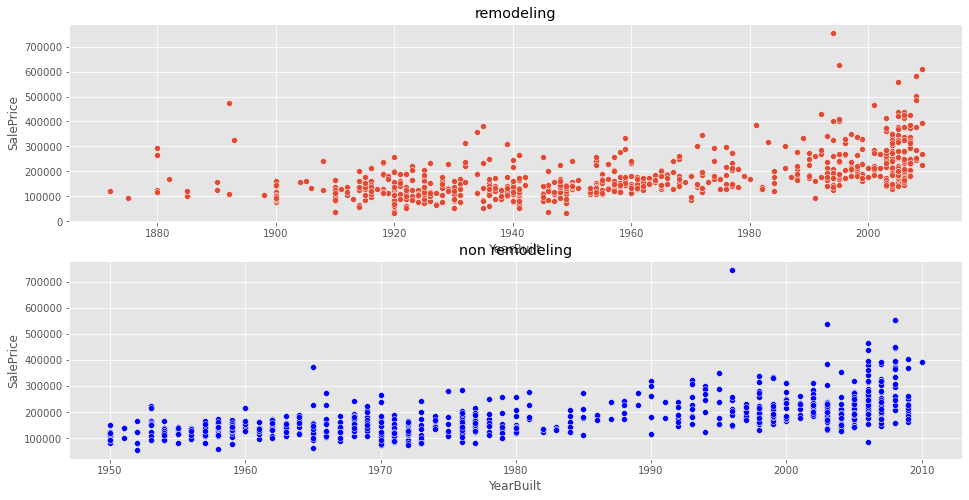

In [23]:
# 리모델링을 했는지의 여부에 따라서 YearBuilt가 달라지는지 확인해보자.
train_remodeling_1 = train[train['remodeling'] == 1]
train_remodeling_0 = train[train['remodeling'] == 0]

fig, ax = plt.subplots(nrows = 2, figsize = (16,8))
sns.scatterplot(data = train_remodeling_1, x = 'YearBuilt', y = 'SalePrice', ax = ax[0])
ax[0].set_title('remodeling')

sns.scatterplot(data = train_remodeling_0, x = 'YearBuilt', y = 'SalePrice', color = 'b',ax =ax [1])
ax[1].set_title('non remodeling')

<AxesSubplot:xlabel='remodeling', ylabel='SalePrice'>

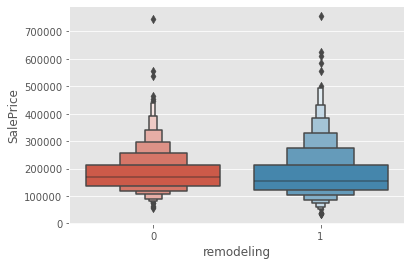

In [24]:
# boxenplot을 이용하여 리모델링 여부가 가격에 영향을 미치는지 확인해보자.
sns.boxenplot(data = train, x = 'remodeling', y = 'SalePrice')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

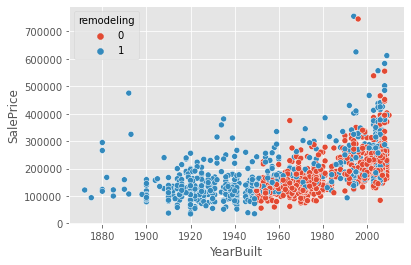

In [25]:
# 우리는 리모델링이 어떻게 데이터가 형성되어있는지 확인해보자.
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', hue = 'remodeling')

<AxesSubplot:xlabel='Year_1950', ylabel='SalePrice'>

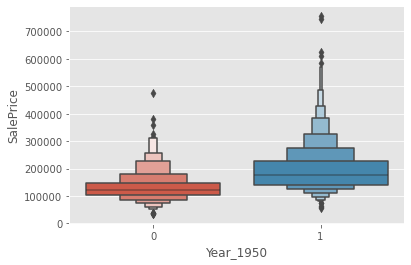

In [26]:
# 1950년 이하의 집은 리모델링을 전부 해줬기 때문에 우리는 1950년도 이상 이하를 이용하여 Year_1950이라는 변수를 만들어주도록 하자.ㅏ
train['Year_1950'] = train['YearBuilt'].apply(lambda x: 1 if x >= 1950 else 0)
sns.boxenplot(data = train, x = 'Year_1950', y = 'SalePrice')

- 확실히 1950년도 이전의 건물과 이후의 건물은 가격면에서 차이가 있다.
- 그러면 우리는 데이터를 범주화 해주도록 하자.
- 1. 1950년 이전의 건물을 0
- 2. 1950년 이후의 건물 중 리모델링을 안한 건물 1
- 3. 1950년 이후에 건물 중 리모델링을 한 건물 2

<AxesSubplot:xlabel='New_Year_feature', ylabel='SalePrice'>

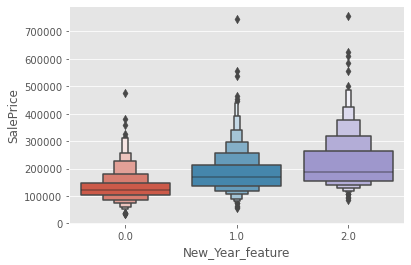

In [27]:
# 확실히 1950년도 이전의 건물과 이후의 건물이 가격면에서 차이가 있었고 remodeling의 변화를 파악하기 위해서 우리는 New_Year_feature라는 변수를 만들어 주도록 하자.
# 1. 1950년 이전의 건물을 0
# 2. 1950년 이후의 건물 중 리모델링을 안한 건물 1
# 3. 1950년 이후에 건물 중 리모델링을 한 건물 2
train['New_Year_feature'] = np.nan
for i in train.index:
    # 처음에 1950년도 이전의 건물을 뽑아내서 0을 할당한다.
    if train.loc[i,'Year_1950'] == 0:
        train.loc[i,'New_Year_feature'] = 0
    else:
    # 1950년도 이상의 건물중에서 remodeling 값이 0이면 1 1이면 2를 할당한다.
        if train.loc[i,'remodeling'] == 0:
            train.loc[i,'New_Year_feature'] = 1
        else:
            train.loc[i,'New_Year_feature'] = 2
            
sns.boxenplot(data = train, x = 'New_Year_feature', y = 'SalePrice')
# 이 변수는 각 값마다 확연한 차이가 있으므로 변수에 넣기로 했다.

BsmtBath_counts의 값 : [1. 0. 2. 3.]
Bath_counts의 값 : [3. 2. 1. 4. 0.]


Text(0.5, 1.0, 'Bath_counts vs SalePrice')

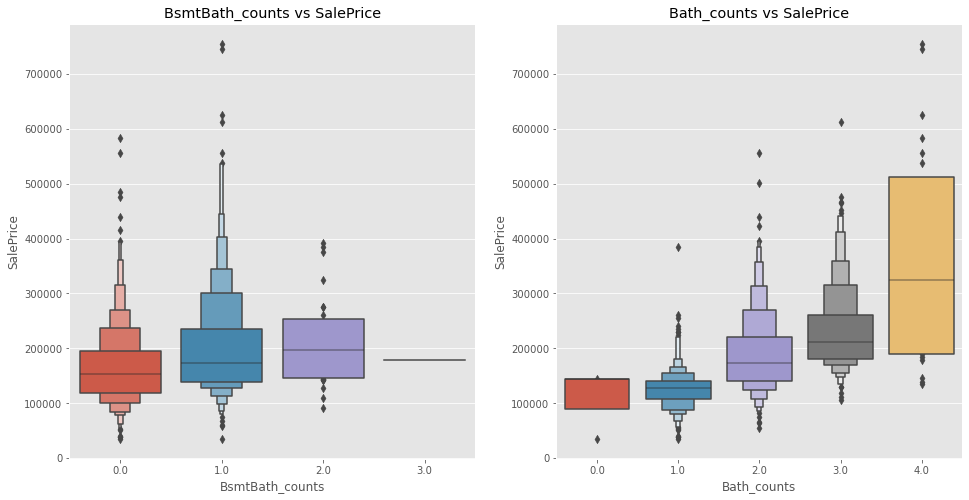

In [28]:
# 지하 화장실의 갯수를 BsmtBath_counts라는 변수로 만들어준다.
# 화장실의 갯수를 Bath_counts라는 변수로 만들어준다.
for i in train.index:
    train.loc[i,'BsmtBath_counts'] = train.loc[i,'BsmtFullBath']+train.loc[i,'BsmtHalfBath']
    train.loc[i,'Bath_counts'] = train.loc[i,'FullBath'] + train.loc[i,'HalfBath']

# 화장실의 갯수를 만든 변수들을 지워준다.
train = train.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis = 1)

# 변수들을 확인한다.
print('BsmtBath_counts의 값 :',train['BsmtBath_counts'].unique())
print('Bath_counts의 값 :', train['Bath_counts'].unique())

# boxenplot으로 SalePrice와의 관계를 확인한다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.boxenplot(data = train, x = 'BsmtBath_counts', y = 'SalePrice', ax = ax[0])
ax[0].set_title('BsmtBath_counts vs SalePrice')

sns.boxenplot(data = train, x = 'Bath_counts', y = 'SalePrice', ax = ax[1])
ax[1].set_title('Bath_counts vs SalePrice')

<AxesSubplot:xlabel='Garage_in', ylabel='SalePrice'>

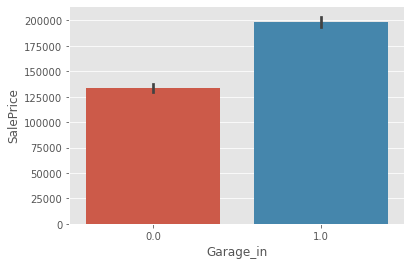

In [29]:
# CarPort와 Detchd는 집과 떨어진 주차장임으로 이것을 제외한 나머지는 Garage_in이라는 변수를 만들어주자.
train.loc[(train['GarageType'] != 'Detchd')& (train['GarageType'] != 'CarPort'),'Garage_in'] = 1
train.loc[(train['GarageType'] == 'Detchd')|(train['GarageType'] == 'CarPort'), 'Garage_in'] = 0

# 그래프를 그려보면 Garage가 집 안에 있는 경우가 더 많은 SalePrice를 갖는다.
sns.barplot(data = train, x = 'Garage_in', y = 'SalePrice')

<AxesSubplot:xlabel='Garage_exist', ylabel='SalePrice'>

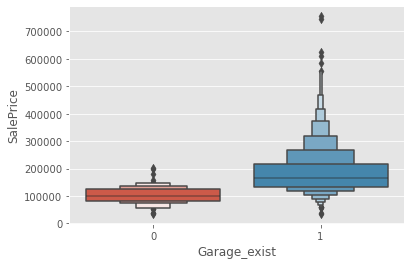

In [30]:
# Garage가 있을 때와 없을 때의 가격을 비교하기 위해 Garage_exist라는 변수를 만들어 준다.
train['Garage_exist'] = train['GarageYrBlt'].apply(lambda x:1 if x > 0 else 0)

sns.boxenplot(data = train, x = 'Garage_exist', y = 'SalePrice')

<AxesSubplot:xlabel='MasVnrArea_exist', ylabel='SalePrice'>

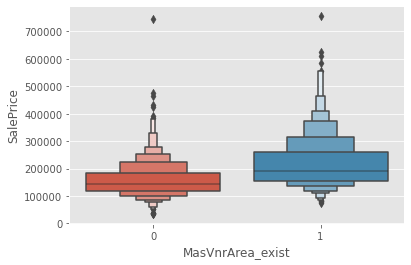

In [31]:
# MasVnrArea를 가지고 있는지 없는지로 변수를 만들어 준다.
train['MasVnrArea_exist'] = train['MasVnrArea'].apply(lambda x:1 if x > 0 else 0)
train=train.drop('MasVnrArea', axis = 1)

sns.boxenplot(data = train, x = 'MasVnrArea_exist', y = 'SalePrice')

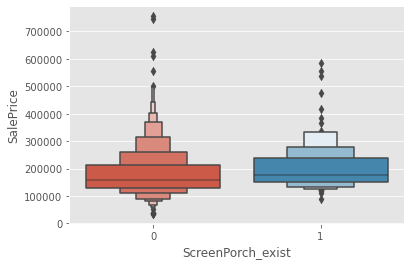

In [32]:
# ScreenPorch가 존재하는 것과 존재하지 않는 것으로 나눠준다.
train['ScreenPorch_exist'] = train['ScreenPorch'].apply(lambda x:1 if x > 0 else 0)
sns.boxenplot(data = train, x = 'ScreenPorch_exist', y = 'SalePrice')
# ScreenPorch가 1인 데이터가 더 높은 가격을 형성하는 것을 볼 수 있다.
train=train.drop('ScreenPorch', axis = 1)

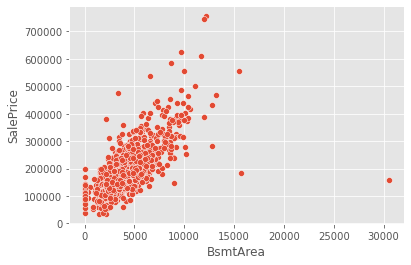

In [33]:
# 지하실의 높이와 지하 총 평방피트를 곱해서 BsmtArea라는 지하의 부피를 구해준다.
for i in train.index:
    train.loc[i,'BsmtArea'] = train.loc[i,'BsmtQual'] * train.loc[i,'TotalBsmtSF']
    
# 그래프를 그려서 관계가 있는지 확인한다.
sns.scatterplot(data = train, x = 'BsmtArea', y = 'SalePrice')

# 다중공선성이 걸리지 않게 변수를 제거해 준다.
train=train.drop(['BsmtQual','TotalBsmtSF'], axis =1)

In [34]:
# object인 column만 뽑아서 라벨 인코딩을 진행해 준다.
a = []
for i in train.columns:
    if train[i].dtype == 'object':
        a.append(i)
        
le = LabelEncoder()
for i in a:
    train[i] = le.fit_transform(train[i])

In [35]:
# 필요하지 않은 변수들이라고 생각되는 변수들을 제거해준다.
train = train.drop(['remodeling','YearRemodAdd','Year_1950','Id'], axis = 1)
train = train.drop(['Exterior1st','Exterior2nd'], axis = 1)
train = train.drop(['GarageCars','Alley'], axis = 1)
train = train.drop(['Condition1','Condition2'], axis = 1)
train = train.drop('Utilities', axis = 1)

# 이상치가 너무 많은 데이터임으로 정규화를 통해서 분석에 용이하게 만든다.
train['SalePrice'] = train['SalePrice'].apply(lambda x: np.log1p(x))

# 연속형 변수들에 로그화 해준다.
train['LotArea'] = train['LotArea'].apply(lambda x:np.log1p(x))
train['GarageArea'] = train['GarageArea'].apply(lambda x:np.log1p(x))
train['GrLivArea'] = train['GrLivArea'].apply(lambda x:np.log1p(x))
train['LotFrontage'] = train['LotFrontage'].apply(lambda x: np.log1p(x))
train['BsmtArea'] = train['BsmtArea'].apply(lambda x: np.log1p(x))

# quality데이터를 각 값에 범주화 되어있는 개수를 나눠준다. 즉, quality데이터를 가지고 하나의 변수를 만들어준다.
quality_data=['OverallQual','ExterQual','KitchenQual','FireplaceQu','GarageQual']
train['quality'] = 0
for i in quality_data:
    train['quality'] += train[i].apply(lambda x: x/len(train[i].unique()))
    train=train.drop(i,axis = 1)

           quality  SalePrice
quality    1.00000    0.82022
SalePrice  0.82022    1.00000


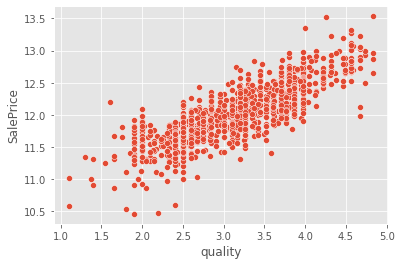

In [36]:
# quality 변수와 SalePrice의 상관관계를 확인해 본다.
sns.scatterplot(data = train, x = 'quality', y = 'SalePrice')
print(train[['quality','SalePrice']].corr())

In [37]:
# 변수가 모델에 넣을 수 있도록 int나 float으로 바뀌었는지 확인한다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int32  
 1   MSZoning           1460 non-null   int32  
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   float64
 4   Street             1460 non-null   int32  
 5   LotShape           1460 non-null   int32  
 6   LandContour        1460 non-null   int32  
 7   LotConfig          1460 non-null   int32  
 8   LandSlope          1460 non-null   int32  
 9   Neighborhood       1460 non-null   int32  
 10  BldgType           1460 non-null   int32  
 11  HouseStyle         1460 non-null   int32  
 12  OverallCond        1460 non-null   int64  
 13  YearBuilt          1460 non-null   int64  
 14  RoofStyle          1460 non-null   int32  
 15  RoofMatl           1460 non-null   int32  
 16  MasVnrType         1460 

In [38]:
# train과 target변수로 바꾸어서 모델에 넣을 준비를 한다.
target=train.loc[:,'SalePrice']
train = train.drop('SalePrice', axis = 1)

# 데이터 중요 feature 추출

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_val_predict
from sklearn.model_selection import StratifiedKFold as stk

In [40]:
# 변수를 train과 test셋으로 나누어서 LinearRegression으로 확인한다.
X_train, X_test, y_train,y_test = train_test_split(train,target, test_size = 0.2, random_state = 42)

lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

RMSE=mean_squared_error(y_pred, y_test)**0.5
print('LinearRegression :', RMSE)

LinearRegression : 0.14454304257260825


In [41]:
# 중요 변수를 추출하기 위해서 statsmodels로 변수들의 P-value를 확인한다.
import statsmodels.api as sm

X = sm.add_constant(train)
y = target

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())
results.pvalues

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     160.5
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        13:53:33   Log-Likelihood:                 879.96
No. Observations:                1460   AIC:                            -1618.
Df Residuals:                    1389   BIC:                            -1243.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.7824      5.69

const                8.586608e-02
MSSubClass           2.437043e-02
MSZoning             9.628690e-01
LotFrontage          5.343548e-01
LotArea              7.490140e-10
                         ...     
Garage_exist         7.987701e-01
MasVnrArea_exist     1.879386e-01
ScreenPorch_exist    1.264562e-03
BsmtArea             5.385298e-03
quality              6.990085e-34
Length: 71, dtype: float64

In [42]:
# p-value가 0.05이상인 변수를 제거해 준다.
data_feature=pd.DataFrame(results.pvalues)
data_feature=data_feature.rename(columns = {0:'feature'})

a = []
for index,feature in zip(data_feature.index, data_feature['feature']):
    if feature > 0.05:
        pass
    else:
        if index != 'const':
            a.append(index)

In [43]:
# 추출한 변수들을 data_feature에 저장한다.
data_feature=train[a]
data_feature.head()

,MSSubClass,LotArea,Street,Neighborhood,OverallCond,YearBuilt,Foundation,BsmtExposure,HeatingQC,CentralAir,2ndFlrSF,GrLivArea,KitchenAbvGr,Functional,Fireplaces,GarageArea,WoodDeckSF,SaleCondition,SameExterior,BsmtBath_counts,Bath_counts,ScreenPorch_exist,BsmtArea,quality
0,5,9.042040,1,5,5,2003,2,1,5,1,854,7.444833,1,6,0,6.308098,0,4,1.0,1.0,3.0,0,8.138857,3.200000
1,0,9.169623,1,24,8,1976,1,4,5,1,0,7.141245,1,6,1,6.133398,298,4,1.0,1.0,2.0,0,8.526945,3.100000
2,5,9.328212,1,5,5,2001,2,2,5,1,866,7.488294,1,6,1,6.411818,0,4,1.0,1.0,3.0,0,8.210940,3.700000
3,6,9.164401,1,6,5,1915,0,1,4,1,756,7.448916,1,6,1,6.466145,0,0,1.0,1.0,1.0,0,7.727094,3.616667
4,5,9.565284,1,15,5,2000,2,3,5,1,1053,7.695758,1,6,1,6.729824,192,4,1.0,1.0,3.0,0,8.429673,3.800000


In [44]:
# 변수를 제거 한 이후에 다시 한번 LinearRegression으로 모델을 돌려본다.
X_train, X_test, y_train,y_test = train_test_split(data_feature,target, test_size = 0.2, random_state = 42)
lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

RMSE=mean_squared_error(y_pred, y_test)**0.5
print('LinearRegression :', RMSE)

LinearRegression : 0.1470689262851156


## p-value로 추출한 변수들로 다시 한번 전처리를 진행한다.

In [45]:
# 전처리를 진행하기 위해서 변수를 데이터프레임에 넣어준다.
data_feature=pd.concat([data_feature,target], axis = 1)

Text(0.5, 1.0, 'SalePrice distribution')

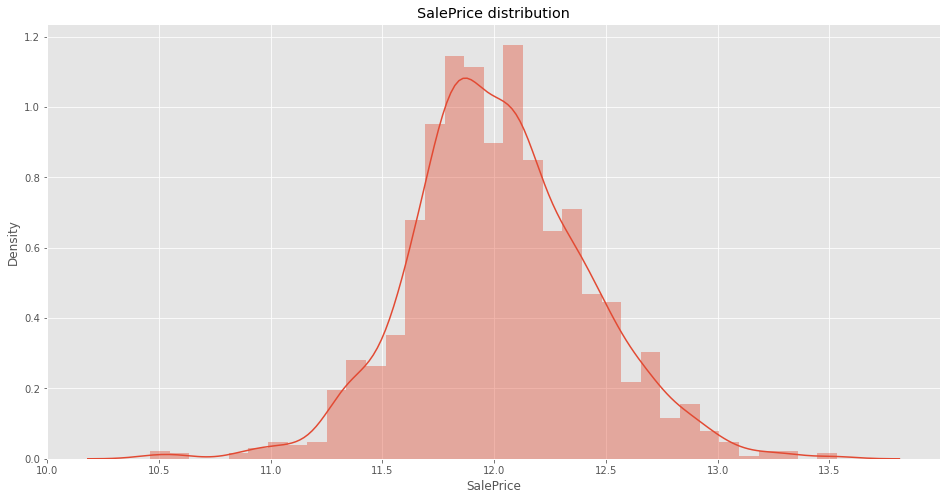

In [46]:
# SalePrice의 분포를 확인한다.
plt.figure(figsize = (16,8))
sns.distplot(data_feature['SalePrice'])
plt.title('SalePrice distribution')

In [47]:
# 결측치가 없는지 확인한다.
data_feature.isnull().sum()

MSSubClass           0
LotArea              0
Street               0
Neighborhood         0
OverallCond          0
YearBuilt            0
Foundation           0
BsmtExposure         0
HeatingQC            0
CentralAir           0
2ndFlrSF             0
GrLivArea            0
KitchenAbvGr         0
Functional           0
Fireplaces           0
GarageArea           0
WoodDeckSF           0
SaleCondition        0
SameExterior         0
BsmtBath_counts      0
Bath_counts          0
ScreenPorch_exist    0
BsmtArea             0
quality              0
SalePrice            0
dtype: int64

## 두개의 변수로 찾아보기

In [48]:
data_feature.columns
data_feature['New_Year_feature'] = train['New_Year_feature']

<AxesSubplot:>

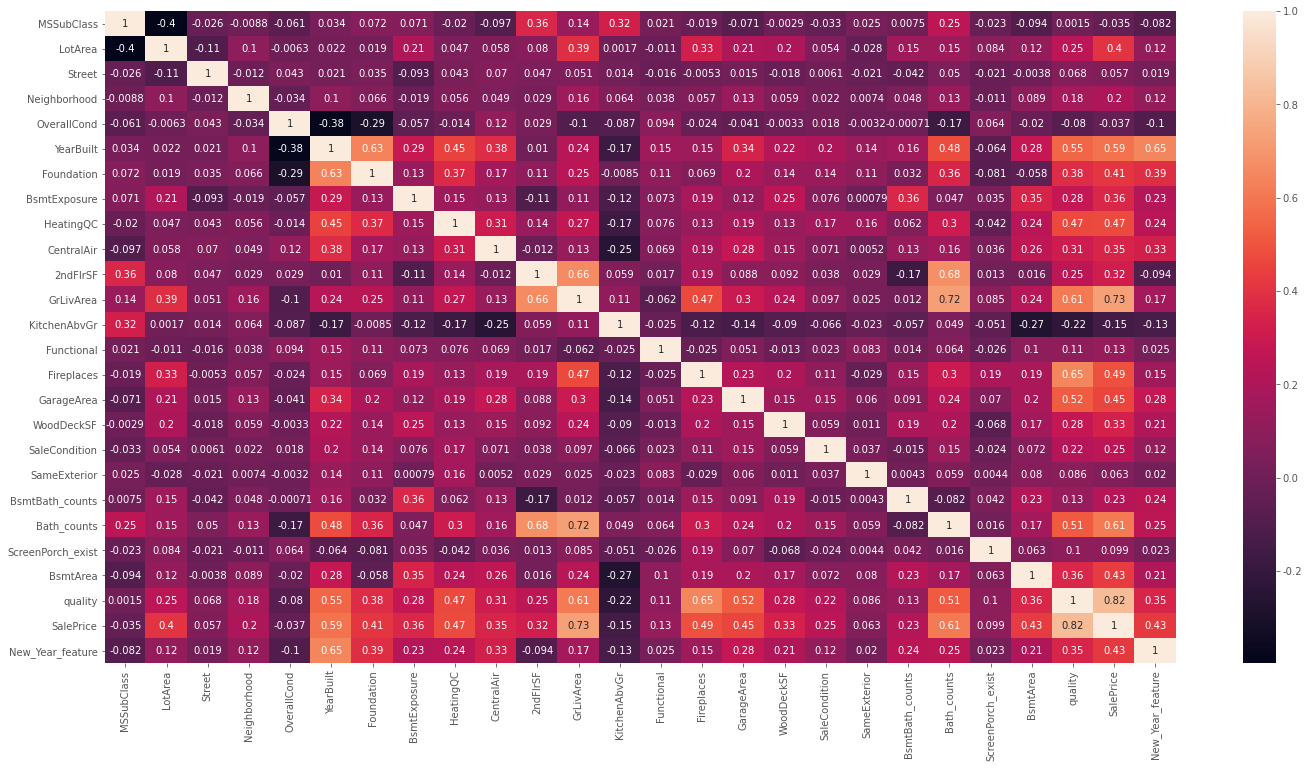

In [49]:
plt.figure(figsize = (24,12))
data_feature_corr=data_feature.corr()
sns.heatmap(data_feature_corr, annot = True)

## 다중공산성 확인해보기

In [50]:
import statsmodels.api as sm

X = sm.add_constant(data_feature.drop('SalePrice', axis = 1))
y = data_feature['SalePrice']

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     418.0
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        13:53:41   Log-Likelihood:                 812.39
No. Observations:                1460   AIC:                            -1573.
Df Residuals:                    1434   BIC:                            -1435.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0729      0.60

In [51]:
# VIF를 이용하여 다중공선성을 확인해주려고 했지만 VIF Factor가 높은 변수들은 필요하다고 판단해서 제거하지 않기로 했다.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data_feature.drop('SalePrice', axis = 1).values, i) for i in range(data_feature.drop('SalePrice',axis = 1).shape[1])]
vif['features'] = data_feature.drop('SalePrice',axis =1).columns
vif

,VIF Factor,features
0,3.923086,MSSubClass
1,593.018213,LotArea
2,253.698802,Street
3,5.599491,Neighborhood
4,32.182641,OverallCond
5,1739.103817,YearBuilt
6,8.544600,Foundation
7,5.030274,BsmtExposure
8,30.823799,HeatingQC
9,21.176579,CentralAir


Text(0.5, 1.0, 'LotArea vs SalePrice')

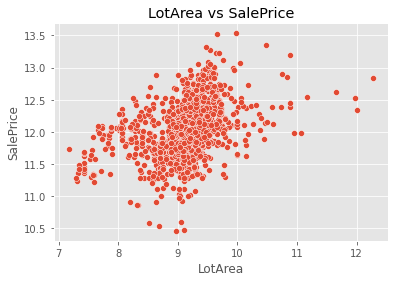

In [52]:
# LotArea와 SalePrice를 비교해본다.
sns.scatterplot(data = data_feature, x = 'LotArea', y = 'SalePrice')
plt.title('LotArea vs SalePrice')

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

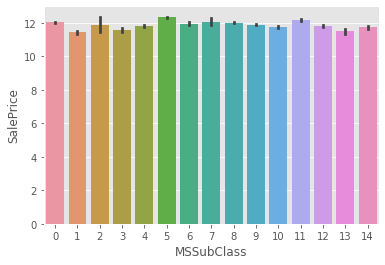

In [53]:
# MSSubClass와 SalePrice를 비교해본다.
sns.barplot(data = data_feature, x = 'MSSubClass', y = 'SalePrice')

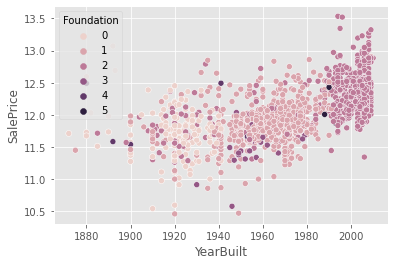

In [54]:
# YearBuilt와 SalePrice를 Foundation별로 비교해 본다.
sns.scatterplot(data = data_feature, x = 'YearBuilt', y = 'SalePrice', hue = 'Foundation')

# YearBuilt 1940년 이전 1940~1990사이 1990 이상 의 데이터들은 각 Foundation을 대표한다고 판단했고 년도별로 나눠주었다.
# YearBuilt를 Foundation을 기준으로 잘라준다.
data_feature.loc[data_feature['YearBuilt'] <= 1940,'Year_Foundation']  = 0
data_feature.loc[(data_feature['YearBuilt'] >= 1940) &(data_feature['YearBuilt'] < 1990), 'Year_Foundation'] = 1
data_feature.loc[(data_feature['YearBuilt'] >= 1990) , 'Year_Foundation'] = 2
data_feature=data_feature.drop('Foundation', axis = 1)

<AxesSubplot:xlabel='Year_Foundation', ylabel='SalePrice'>

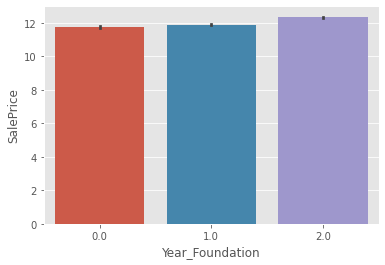

In [55]:
# Year_Foundattion과 SalePrice를 비교해준다.
sns.barplot(data = data_feature, x = 'Year_Foundation', y = 'SalePrice')

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice'>

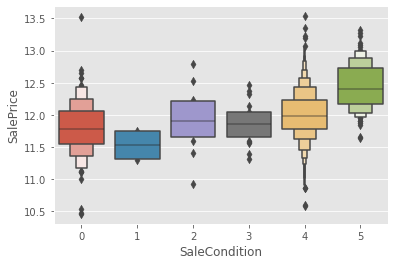

In [56]:
# SaleCondition과 SalePrice를 비교해준다.
sns.boxenplot(data = data_feature, x = 'SaleCondition', y = 'SalePrice')

# 특징을 발견하지 못해서 지워주도록 하자.

## 2ndFlrSF

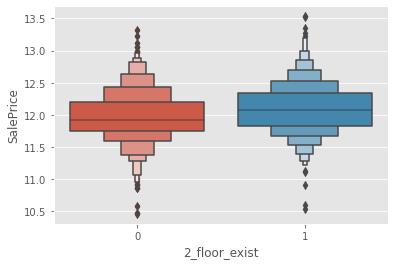

In [57]:
# 2ndFlrSF와 SalePrice를 비교해준다.
sns.scatterplot(data = data_feature, x = '2ndFlrSF',y = 'SalePrice')

# 0에 몰려있는 데이터가 많기 때문에 2층이 있으면 1 없으면 0으로 바꿔준다.
data_feature['2_floor_exist'] = data_feature['2ndFlrSF'].apply(lambda x:1 if x >0  else 0)

# 1과 0 사이에 차이가 있다.
sns.boxenplot(data = data_feature, x = '2_floor_exist', y = 'SalePrice')

# 다중공선성을 피하기 위해서 변수를 제거해 준다.
data_feature = data_feature.drop('2ndFlrSF', axis = 1)

## KitchenAbvGr

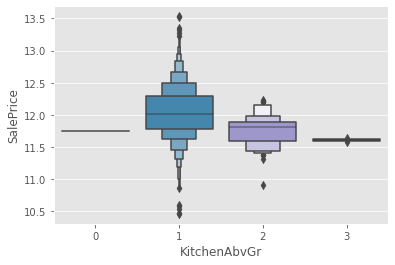

In [58]:
# KitchenAbvGr과 SalePrice를 비교해준다.
sns.boxenplot(data = data_feature, x = 'KitchenAbvGr', y = 'SalePrice')

# 특징이 있는 변수라고 판단되지 않았고 변수를 제거해 주도록 하자.
data_feature=data_feature.drop('KitchenAbvGr', axis = 1)

## HeatingQC

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

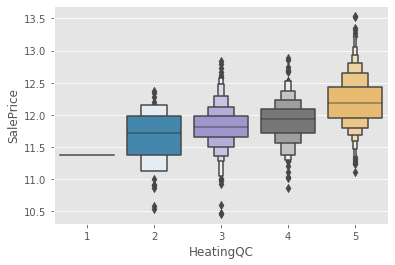

In [59]:
# HeatingQC와 SalePrice를 비교해준다.
# HeatingQC가 올라갈수록 높은 가격을 형성함으로 지워주지 않도록 한다.
sns.boxenplot(data = data_feature, x = 'HeatingQC', y = 'SalePrice')

## FirePlaces

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

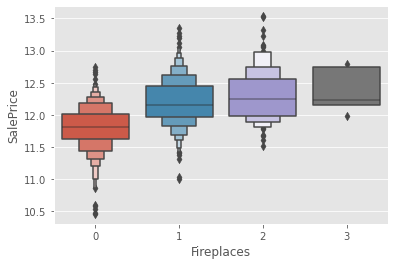

In [60]:
# FirePlaces와 SalePrice를 비교해준다.
# Fireplaces의 값이 올라갈수록 높은 SalePrice를 갖는다.
sns.boxenplot(data = data_feature, x = 'Fireplaces', y = 'SalePrice')

## Stacking ensemble을 사용한 모델링

In [61]:
from sklearn.linear_model import Ridge,Lasso,HuberRegressor,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

models=[LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),CatBoostRegressor()]
final_model = XGBRegressor()
def stacking_ensemble(models, data = None, target = None, test_size = 0.2,
                      n_folds = 5, final_model = final_model):
    # kfold를 사용한다.
    kfold = KFold(n_splits = n_folds)
    
    # 데이터를 train데이터와 test 데이터로 나누어준다.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = test_size, random_state = 100)
    
    # 각 모델의 평균값을 넣어주기 위해서 공간을 만든다.
    final_train_predict = np.zeros((X_train.shape[0], len(models)))
    final_test_predict = np.zeros((X_test.shape[0], len(models)))
    
    for model_count, model in enumerate(models):
        
        # 각 모델마다 k_fold의 값들을 넣어주기 위해서 공간을 만든다.
        test_predict = np.zeros((X_test.shape[0], n_folds))
        
        # X_train의 데이터를 train과 valid로 나누기 
        for fold_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
            X_train_n = X_train.iloc[train_idx]
            y_train_n = y_train.iloc[train_idx]
            X_test_n = X_train.iloc[valid_idx]
        
            # 개별 모델을 학습한다.
            model = model.fit(X_train_n, y_train_n)
            final_train_predict[valid_idx, model_count] = model.predict(X_test_n)
            test_predict[:, fold_count] = model.predict(X_test)
            
        # 교차검증을 한 데이터를 가지고 평균 구하기    
        final_test_predict[:,model_count] = np.mean(test_predict, axis = 1)
                
    # 최종 모델로 학습시키기
    final_model = final_model.fit(final_train_predict, y_train)
    y_pred = final_model.predict(final_test_predict)
    
    # RMSE값 반환하기
    test_rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(test_rmse)

In [62]:
stacking_ensemble(models, data = data_feature.drop('SalePrice', axis = 1),
                  target = data_feature['SalePrice'])

Learning rate set to 0.038559
0:	learn: 0.3873385	total: 180ms	remaining: 3m
1:	learn: 0.3771564	total: 186ms	remaining: 1m 32s
2:	learn: 0.3675682	total: 189ms	remaining: 1m 2s
3:	learn: 0.3587320	total: 191ms	remaining: 47.6s
4:	learn: 0.3501886	total: 194ms	remaining: 38.5s
5:	learn: 0.3416653	total: 196ms	remaining: 32.4s
6:	learn: 0.3337335	total: 197ms	remaining: 28s
7:	learn: 0.3264006	total: 199ms	remaining: 24.7s
8:	learn: 0.3186460	total: 201ms	remaining: 22.1s
9:	learn: 0.3114868	total: 203ms	remaining: 20.1s
10:	learn: 0.3047723	total: 204ms	remaining: 18.4s
11:	learn: 0.2979424	total: 206ms	remaining: 16.9s
12:	learn: 0.2921440	total: 207ms	remaining: 15.7s
13:	learn: 0.2855358	total: 209ms	remaining: 14.7s
14:	learn: 0.2796449	total: 211ms	remaining: 13.8s
15:	learn: 0.2739032	total: 212ms	remaining: 13s
16:	learn: 0.2681069	total: 214ms	remaining: 12.4s
17:	learn: 0.2631419	total: 216ms	remaining: 11.8s
18:	learn: 0.2584604	total: 217ms	remaining: 11.2s
19:	learn: 0.2539

203:	learn: 0.0923474	total: 527ms	remaining: 2.05s
204:	learn: 0.0921576	total: 528ms	remaining: 2.05s
205:	learn: 0.0919747	total: 530ms	remaining: 2.04s
206:	learn: 0.0918527	total: 532ms	remaining: 2.04s
207:	learn: 0.0916726	total: 533ms	remaining: 2.03s
208:	learn: 0.0915931	total: 535ms	remaining: 2.02s
209:	learn: 0.0913935	total: 537ms	remaining: 2.02s
210:	learn: 0.0912147	total: 538ms	remaining: 2.01s
211:	learn: 0.0910859	total: 540ms	remaining: 2.01s
212:	learn: 0.0908998	total: 542ms	remaining: 2s
213:	learn: 0.0906466	total: 543ms	remaining: 1.99s
214:	learn: 0.0905556	total: 545ms	remaining: 1.99s
215:	learn: 0.0903848	total: 547ms	remaining: 1.98s
216:	learn: 0.0902297	total: 548ms	remaining: 1.98s
217:	learn: 0.0901470	total: 549ms	remaining: 1.97s
218:	learn: 0.0900253	total: 551ms	remaining: 1.96s
219:	learn: 0.0898777	total: 553ms	remaining: 1.96s
220:	learn: 0.0896977	total: 554ms	remaining: 1.95s
221:	learn: 0.0895357	total: 556ms	remaining: 1.95s
222:	learn: 0.0

402:	learn: 0.0665132	total: 866ms	remaining: 1.28s
403:	learn: 0.0663981	total: 868ms	remaining: 1.28s
404:	learn: 0.0663069	total: 870ms	remaining: 1.28s
405:	learn: 0.0661622	total: 872ms	remaining: 1.27s
406:	learn: 0.0660417	total: 873ms	remaining: 1.27s
407:	learn: 0.0659628	total: 875ms	remaining: 1.27s
408:	learn: 0.0659028	total: 877ms	remaining: 1.27s
409:	learn: 0.0657888	total: 879ms	remaining: 1.26s
410:	learn: 0.0657055	total: 880ms	remaining: 1.26s
411:	learn: 0.0655593	total: 882ms	remaining: 1.26s
412:	learn: 0.0654910	total: 883ms	remaining: 1.25s
413:	learn: 0.0654221	total: 885ms	remaining: 1.25s
414:	learn: 0.0653334	total: 887ms	remaining: 1.25s
415:	learn: 0.0652416	total: 888ms	remaining: 1.25s
416:	learn: 0.0651345	total: 890ms	remaining: 1.24s
417:	learn: 0.0650276	total: 892ms	remaining: 1.24s
418:	learn: 0.0649360	total: 893ms	remaining: 1.24s
419:	learn: 0.0648574	total: 895ms	remaining: 1.24s
420:	learn: 0.0647246	total: 897ms	remaining: 1.23s
421:	learn: 

605:	learn: 0.0512405	total: 1.21s	remaining: 786ms
606:	learn: 0.0511819	total: 1.21s	remaining: 784ms
607:	learn: 0.0510892	total: 1.21s	remaining: 782ms
608:	learn: 0.0510242	total: 1.21s	remaining: 780ms
609:	learn: 0.0509381	total: 1.22s	remaining: 778ms
610:	learn: 0.0509263	total: 1.22s	remaining: 776ms
611:	learn: 0.0509215	total: 1.22s	remaining: 773ms
612:	learn: 0.0508556	total: 1.22s	remaining: 771ms
613:	learn: 0.0507880	total: 1.22s	remaining: 769ms
614:	learn: 0.0507170	total: 1.22s	remaining: 767ms
615:	learn: 0.0506949	total: 1.23s	remaining: 765ms
616:	learn: 0.0506552	total: 1.23s	remaining: 762ms
617:	learn: 0.0506101	total: 1.23s	remaining: 760ms
618:	learn: 0.0506072	total: 1.23s	remaining: 758ms
619:	learn: 0.0505399	total: 1.23s	remaining: 756ms
620:	learn: 0.0504510	total: 1.23s	remaining: 754ms
621:	learn: 0.0503767	total: 1.24s	remaining: 751ms
622:	learn: 0.0502725	total: 1.24s	remaining: 749ms
623:	learn: 0.0502673	total: 1.24s	remaining: 747ms
624:	learn: 

795:	learn: 0.0420937	total: 1.55s	remaining: 399ms
796:	learn: 0.0420366	total: 1.56s	remaining: 397ms
797:	learn: 0.0419493	total: 1.56s	remaining: 395ms
798:	learn: 0.0419053	total: 1.56s	remaining: 393ms
799:	learn: 0.0418543	total: 1.56s	remaining: 391ms
800:	learn: 0.0418187	total: 1.56s	remaining: 389ms
801:	learn: 0.0417531	total: 1.57s	remaining: 387ms
802:	learn: 0.0417034	total: 1.57s	remaining: 385ms
803:	learn: 0.0416687	total: 1.57s	remaining: 383ms
804:	learn: 0.0416035	total: 1.57s	remaining: 381ms
805:	learn: 0.0415996	total: 1.57s	remaining: 379ms
806:	learn: 0.0415792	total: 1.57s	remaining: 377ms
807:	learn: 0.0415460	total: 1.58s	remaining: 375ms
808:	learn: 0.0415131	total: 1.58s	remaining: 373ms
809:	learn: 0.0414989	total: 1.58s	remaining: 371ms
810:	learn: 0.0414582	total: 1.58s	remaining: 369ms
811:	learn: 0.0414189	total: 1.58s	remaining: 367ms
812:	learn: 0.0413680	total: 1.59s	remaining: 365ms
813:	learn: 0.0413628	total: 1.59s	remaining: 363ms
814:	learn: 

980:	learn: 0.0353176	total: 1.9s	remaining: 36.8ms
981:	learn: 0.0352813	total: 1.9s	remaining: 34.8ms
982:	learn: 0.0352349	total: 1.9s	remaining: 32.9ms
983:	learn: 0.0352317	total: 1.9s	remaining: 31ms
984:	learn: 0.0351968	total: 1.91s	remaining: 29ms
985:	learn: 0.0351948	total: 1.91s	remaining: 27.1ms
986:	learn: 0.0351693	total: 1.91s	remaining: 25.1ms
987:	learn: 0.0351393	total: 1.91s	remaining: 23.2ms
988:	learn: 0.0351038	total: 1.91s	remaining: 21.3ms
989:	learn: 0.0350559	total: 1.91s	remaining: 19.3ms
990:	learn: 0.0350276	total: 1.92s	remaining: 17.4ms
991:	learn: 0.0349848	total: 1.92s	remaining: 15.5ms
992:	learn: 0.0349539	total: 1.92s	remaining: 13.5ms
993:	learn: 0.0349101	total: 1.92s	remaining: 11.6ms
994:	learn: 0.0348754	total: 1.93s	remaining: 9.69ms
995:	learn: 0.0348347	total: 1.93s	remaining: 7.76ms
996:	learn: 0.0347975	total: 1.93s	remaining: 5.82ms
997:	learn: 0.0347960	total: 1.94s	remaining: 3.88ms
998:	learn: 0.0347940	total: 1.94s	remaining: 1.94ms
9

234:	learn: 0.0912353	total: 412ms	remaining: 1.34s
235:	learn: 0.0909399	total: 414ms	remaining: 1.34s
236:	learn: 0.0908531	total: 416ms	remaining: 1.34s
237:	learn: 0.0908242	total: 417ms	remaining: 1.34s
238:	learn: 0.0907588	total: 419ms	remaining: 1.33s
239:	learn: 0.0907300	total: 421ms	remaining: 1.33s
240:	learn: 0.0906558	total: 423ms	remaining: 1.33s
241:	learn: 0.0905852	total: 424ms	remaining: 1.33s
242:	learn: 0.0905087	total: 426ms	remaining: 1.33s
243:	learn: 0.0902716	total: 428ms	remaining: 1.32s
244:	learn: 0.0902091	total: 429ms	remaining: 1.32s
245:	learn: 0.0901547	total: 431ms	remaining: 1.32s
246:	learn: 0.0900598	total: 433ms	remaining: 1.32s
247:	learn: 0.0898445	total: 435ms	remaining: 1.32s
248:	learn: 0.0896180	total: 437ms	remaining: 1.32s
249:	learn: 0.0895594	total: 438ms	remaining: 1.31s
250:	learn: 0.0893638	total: 440ms	remaining: 1.31s
251:	learn: 0.0891640	total: 442ms	remaining: 1.31s
252:	learn: 0.0890342	total: 443ms	remaining: 1.31s
253:	learn: 

423:	learn: 0.0703255	total: 754ms	remaining: 1.02s
424:	learn: 0.0702131	total: 756ms	remaining: 1.02s
425:	learn: 0.0700932	total: 757ms	remaining: 1.02s
426:	learn: 0.0699146	total: 759ms	remaining: 1.02s
427:	learn: 0.0698084	total: 761ms	remaining: 1.02s
428:	learn: 0.0697380	total: 763ms	remaining: 1.01s
429:	learn: 0.0695928	total: 765ms	remaining: 1.01s
430:	learn: 0.0694675	total: 766ms	remaining: 1.01s
431:	learn: 0.0693530	total: 768ms	remaining: 1.01s
432:	learn: 0.0692699	total: 770ms	remaining: 1.01s
433:	learn: 0.0691736	total: 772ms	remaining: 1.01s
434:	learn: 0.0691682	total: 774ms	remaining: 1s
435:	learn: 0.0691617	total: 775ms	remaining: 1s
436:	learn: 0.0690047	total: 777ms	remaining: 1s
437:	learn: 0.0689212	total: 779ms	remaining: 999ms
438:	learn: 0.0687959	total: 781ms	remaining: 998ms
439:	learn: 0.0687329	total: 782ms	remaining: 996ms
440:	learn: 0.0686599	total: 784ms	remaining: 994ms
441:	learn: 0.0685080	total: 786ms	remaining: 993ms
442:	learn: 0.0683940

607:	learn: 0.0561153	total: 1.09s	remaining: 706ms
608:	learn: 0.0560217	total: 1.1s	remaining: 704ms
609:	learn: 0.0559587	total: 1.1s	remaining: 702ms
610:	learn: 0.0559266	total: 1.1s	remaining: 701ms
611:	learn: 0.0558628	total: 1.1s	remaining: 699ms
612:	learn: 0.0558553	total: 1.1s	remaining: 697ms
613:	learn: 0.0558179	total: 1.1s	remaining: 695ms
614:	learn: 0.0557621	total: 1.11s	remaining: 693ms
615:	learn: 0.0556607	total: 1.11s	remaining: 691ms
616:	learn: 0.0556161	total: 1.11s	remaining: 689ms
617:	learn: 0.0555714	total: 1.11s	remaining: 688ms
618:	learn: 0.0554993	total: 1.11s	remaining: 686ms
619:	learn: 0.0554517	total: 1.12s	remaining: 684ms
620:	learn: 0.0553813	total: 1.12s	remaining: 682ms
621:	learn: 0.0553744	total: 1.12s	remaining: 681ms
622:	learn: 0.0552831	total: 1.12s	remaining: 679ms
623:	learn: 0.0552245	total: 1.12s	remaining: 677ms
624:	learn: 0.0551659	total: 1.13s	remaining: 675ms
625:	learn: 0.0550855	total: 1.13s	remaining: 674ms
626:	learn: 0.0550

792:	learn: 0.0460752	total: 1.44s	remaining: 375ms
793:	learn: 0.0460081	total: 1.44s	remaining: 373ms
794:	learn: 0.0459502	total: 1.44s	remaining: 372ms
795:	learn: 0.0459205	total: 1.44s	remaining: 370ms
796:	learn: 0.0458414	total: 1.44s	remaining: 368ms
797:	learn: 0.0457971	total: 1.45s	remaining: 366ms
798:	learn: 0.0457930	total: 1.45s	remaining: 364ms
799:	learn: 0.0457443	total: 1.45s	remaining: 362ms
800:	learn: 0.0457041	total: 1.45s	remaining: 361ms
801:	learn: 0.0456432	total: 1.45s	remaining: 359ms
802:	learn: 0.0456390	total: 1.46s	remaining: 357ms
803:	learn: 0.0455610	total: 1.46s	remaining: 355ms
804:	learn: 0.0455140	total: 1.46s	remaining: 354ms
805:	learn: 0.0454505	total: 1.46s	remaining: 352ms
806:	learn: 0.0454174	total: 1.46s	remaining: 350ms
807:	learn: 0.0453706	total: 1.47s	remaining: 348ms
808:	learn: 0.0453061	total: 1.47s	remaining: 346ms
809:	learn: 0.0452530	total: 1.47s	remaining: 344ms
810:	learn: 0.0452134	total: 1.47s	remaining: 343ms
811:	learn: 

981:	learn: 0.0379627	total: 1.78s	remaining: 32.6ms
982:	learn: 0.0379237	total: 1.78s	remaining: 30.8ms
983:	learn: 0.0378735	total: 1.78s	remaining: 29ms
984:	learn: 0.0378291	total: 1.78s	remaining: 27.2ms
985:	learn: 0.0377980	total: 1.79s	remaining: 25.4ms
986:	learn: 0.0377786	total: 1.79s	remaining: 23.6ms
987:	learn: 0.0377297	total: 1.79s	remaining: 21.7ms
988:	learn: 0.0376859	total: 1.79s	remaining: 19.9ms
989:	learn: 0.0376433	total: 1.79s	remaining: 18.1ms
990:	learn: 0.0376178	total: 1.79s	remaining: 16.3ms
991:	learn: 0.0375679	total: 1.8s	remaining: 14.5ms
992:	learn: 0.0375216	total: 1.8s	remaining: 12.7ms
993:	learn: 0.0374845	total: 1.8s	remaining: 10.9ms
994:	learn: 0.0374312	total: 1.8s	remaining: 9.06ms
995:	learn: 0.0374294	total: 1.8s	remaining: 7.24ms
996:	learn: 0.0374283	total: 1.8s	remaining: 5.43ms
997:	learn: 0.0373970	total: 1.81s	remaining: 3.62ms
998:	learn: 0.0373819	total: 1.81s	remaining: 1.81ms
999:	learn: 0.0373812	total: 1.81s	remaining: 0us
Lear

233:	learn: 0.0902166	total: 414ms	remaining: 1.35s
234:	learn: 0.0901188	total: 416ms	remaining: 1.35s
235:	learn: 0.0899321	total: 418ms	remaining: 1.35s
236:	learn: 0.0898710	total: 420ms	remaining: 1.35s
237:	learn: 0.0897964	total: 422ms	remaining: 1.35s
238:	learn: 0.0896522	total: 423ms	remaining: 1.35s
239:	learn: 0.0894137	total: 425ms	remaining: 1.35s
240:	learn: 0.0892438	total: 427ms	remaining: 1.34s
241:	learn: 0.0891608	total: 429ms	remaining: 1.34s
242:	learn: 0.0890849	total: 431ms	remaining: 1.34s
243:	learn: 0.0889217	total: 432ms	remaining: 1.34s
244:	learn: 0.0888433	total: 434ms	remaining: 1.34s
245:	learn: 0.0886994	total: 436ms	remaining: 1.34s
246:	learn: 0.0886460	total: 438ms	remaining: 1.33s
247:	learn: 0.0885449	total: 440ms	remaining: 1.33s
248:	learn: 0.0883246	total: 441ms	remaining: 1.33s
249:	learn: 0.0881465	total: 443ms	remaining: 1.33s
250:	learn: 0.0879979	total: 445ms	remaining: 1.33s
251:	learn: 0.0878649	total: 447ms	remaining: 1.33s
252:	learn: 

416:	learn: 0.0699738	total: 754ms	remaining: 1.05s
417:	learn: 0.0698815	total: 756ms	remaining: 1.05s
418:	learn: 0.0697613	total: 758ms	remaining: 1.05s
419:	learn: 0.0695921	total: 760ms	remaining: 1.05s
420:	learn: 0.0694607	total: 762ms	remaining: 1.05s
421:	learn: 0.0693687	total: 764ms	remaining: 1.05s
422:	learn: 0.0692860	total: 766ms	remaining: 1.04s
423:	learn: 0.0691618	total: 767ms	remaining: 1.04s
424:	learn: 0.0690347	total: 769ms	remaining: 1.04s
425:	learn: 0.0689363	total: 771ms	remaining: 1.04s
426:	learn: 0.0688801	total: 773ms	remaining: 1.04s
427:	learn: 0.0687926	total: 775ms	remaining: 1.03s
428:	learn: 0.0687318	total: 777ms	remaining: 1.03s
429:	learn: 0.0686818	total: 779ms	remaining: 1.03s
430:	learn: 0.0685952	total: 780ms	remaining: 1.03s
431:	learn: 0.0685433	total: 782ms	remaining: 1.03s
432:	learn: 0.0684711	total: 784ms	remaining: 1.03s
433:	learn: 0.0683803	total: 786ms	remaining: 1.02s
434:	learn: 0.0682904	total: 787ms	remaining: 1.02s
435:	learn: 

607:	learn: 0.0556952	total: 1.1s	remaining: 708ms
608:	learn: 0.0556198	total: 1.1s	remaining: 706ms
609:	learn: 0.0556027	total: 1.1s	remaining: 704ms
610:	learn: 0.0554964	total: 1.1s	remaining: 702ms
611:	learn: 0.0554326	total: 1.1s	remaining: 701ms
612:	learn: 0.0553690	total: 1.11s	remaining: 699ms
613:	learn: 0.0553038	total: 1.11s	remaining: 697ms
614:	learn: 0.0552329	total: 1.11s	remaining: 696ms
615:	learn: 0.0551600	total: 1.11s	remaining: 694ms
616:	learn: 0.0550676	total: 1.11s	remaining: 692ms
617:	learn: 0.0550125	total: 1.12s	remaining: 690ms
618:	learn: 0.0549848	total: 1.12s	remaining: 688ms
619:	learn: 0.0549363	total: 1.12s	remaining: 687ms
620:	learn: 0.0549325	total: 1.12s	remaining: 685ms
621:	learn: 0.0548930	total: 1.12s	remaining: 683ms
622:	learn: 0.0547811	total: 1.13s	remaining: 681ms
623:	learn: 0.0546983	total: 1.13s	remaining: 679ms
624:	learn: 0.0546312	total: 1.13s	remaining: 678ms
625:	learn: 0.0545503	total: 1.13s	remaining: 676ms
626:	learn: 0.054

792:	learn: 0.0462484	total: 1.44s	remaining: 376ms
793:	learn: 0.0462118	total: 1.44s	remaining: 374ms
794:	learn: 0.0461549	total: 1.44s	remaining: 372ms
795:	learn: 0.0461103	total: 1.44s	remaining: 370ms
796:	learn: 0.0460738	total: 1.45s	remaining: 368ms
797:	learn: 0.0460139	total: 1.45s	remaining: 367ms
798:	learn: 0.0459533	total: 1.45s	remaining: 365ms
799:	learn: 0.0459321	total: 1.45s	remaining: 363ms
800:	learn: 0.0458845	total: 1.45s	remaining: 361ms
801:	learn: 0.0458492	total: 1.46s	remaining: 359ms
802:	learn: 0.0458141	total: 1.46s	remaining: 358ms
803:	learn: 0.0457712	total: 1.46s	remaining: 356ms
804:	learn: 0.0457235	total: 1.46s	remaining: 354ms
805:	learn: 0.0456593	total: 1.46s	remaining: 352ms
806:	learn: 0.0456176	total: 1.46s	remaining: 350ms
807:	learn: 0.0455648	total: 1.47s	remaining: 349ms
808:	learn: 0.0455268	total: 1.47s	remaining: 347ms
809:	learn: 0.0454760	total: 1.47s	remaining: 345ms
810:	learn: 0.0454288	total: 1.47s	remaining: 343ms
811:	learn: 

978:	learn: 0.0386041	total: 1.78s	remaining: 38.2ms
979:	learn: 0.0385391	total: 1.78s	remaining: 36.4ms
980:	learn: 0.0384879	total: 1.78s	remaining: 34.5ms
981:	learn: 0.0384469	total: 1.78s	remaining: 32.7ms
982:	learn: 0.0384195	total: 1.79s	remaining: 30.9ms
983:	learn: 0.0383852	total: 1.79s	remaining: 29.1ms
984:	learn: 0.0383516	total: 1.79s	remaining: 27.3ms
985:	learn: 0.0383143	total: 1.79s	remaining: 25.4ms
986:	learn: 0.0382925	total: 1.79s	remaining: 23.6ms
987:	learn: 0.0382825	total: 1.79s	remaining: 21.8ms
988:	learn: 0.0382372	total: 1.8s	remaining: 20ms
989:	learn: 0.0381955	total: 1.8s	remaining: 18.2ms
990:	learn: 0.0381440	total: 1.8s	remaining: 16.4ms
991:	learn: 0.0380868	total: 1.8s	remaining: 14.5ms
992:	learn: 0.0380785	total: 1.8s	remaining: 12.7ms
993:	learn: 0.0380351	total: 1.8s	remaining: 10.9ms
994:	learn: 0.0379672	total: 1.81s	remaining: 9.08ms
995:	learn: 0.0379003	total: 1.81s	remaining: 7.27ms
996:	learn: 0.0378654	total: 1.81s	remaining: 5.45ms
9

140:	learn: 0.1118168	total: 254ms	remaining: 1.55s
141:	learn: 0.1115025	total: 256ms	remaining: 1.55s
142:	learn: 0.1113018	total: 258ms	remaining: 1.55s
143:	learn: 0.1110506	total: 260ms	remaining: 1.55s
144:	learn: 0.1107255	total: 262ms	remaining: 1.54s
145:	learn: 0.1105444	total: 264ms	remaining: 1.54s
146:	learn: 0.1103200	total: 265ms	remaining: 1.54s
147:	learn: 0.1100414	total: 267ms	remaining: 1.54s
148:	learn: 0.1098767	total: 269ms	remaining: 1.53s
149:	learn: 0.1097510	total: 270ms	remaining: 1.53s
150:	learn: 0.1094738	total: 272ms	remaining: 1.53s
151:	learn: 0.1092581	total: 275ms	remaining: 1.53s
152:	learn: 0.1090985	total: 276ms	remaining: 1.53s
153:	learn: 0.1089335	total: 278ms	remaining: 1.53s
154:	learn: 0.1087287	total: 280ms	remaining: 1.53s
155:	learn: 0.1085919	total: 282ms	remaining: 1.52s
156:	learn: 0.1083729	total: 283ms	remaining: 1.52s
157:	learn: 0.1081787	total: 285ms	remaining: 1.52s
158:	learn: 0.1080124	total: 287ms	remaining: 1.52s
159:	learn: 

318:	learn: 0.0859410	total: 594ms	remaining: 1.27s
319:	learn: 0.0858433	total: 596ms	remaining: 1.27s
320:	learn: 0.0856854	total: 598ms	remaining: 1.26s
321:	learn: 0.0855234	total: 600ms	remaining: 1.26s
322:	learn: 0.0853990	total: 602ms	remaining: 1.26s
323:	learn: 0.0853021	total: 606ms	remaining: 1.26s
324:	learn: 0.0852321	total: 608ms	remaining: 1.26s
325:	learn: 0.0851405	total: 610ms	remaining: 1.26s
326:	learn: 0.0851250	total: 613ms	remaining: 1.26s
327:	learn: 0.0851119	total: 614ms	remaining: 1.26s
328:	learn: 0.0849865	total: 616ms	remaining: 1.26s
329:	learn: 0.0848942	total: 619ms	remaining: 1.26s
330:	learn: 0.0848794	total: 623ms	remaining: 1.26s
331:	learn: 0.0846968	total: 625ms	remaining: 1.26s
332:	learn: 0.0846845	total: 627ms	remaining: 1.26s
333:	learn: 0.0845615	total: 629ms	remaining: 1.25s
334:	learn: 0.0844396	total: 631ms	remaining: 1.25s
335:	learn: 0.0842432	total: 634ms	remaining: 1.25s
336:	learn: 0.0841284	total: 637ms	remaining: 1.25s
337:	learn: 

545:	learn: 0.0643098	total: 1.1s	remaining: 917ms
546:	learn: 0.0642349	total: 1.1s	remaining: 915ms
547:	learn: 0.0641490	total: 1.11s	remaining: 913ms
548:	learn: 0.0640824	total: 1.11s	remaining: 911ms
549:	learn: 0.0639803	total: 1.11s	remaining: 908ms
550:	learn: 0.0638895	total: 1.11s	remaining: 906ms
551:	learn: 0.0637856	total: 1.11s	remaining: 904ms
552:	learn: 0.0636936	total: 1.11s	remaining: 902ms
553:	learn: 0.0635997	total: 1.12s	remaining: 900ms
554:	learn: 0.0635093	total: 1.12s	remaining: 898ms
555:	learn: 0.0634307	total: 1.12s	remaining: 896ms
556:	learn: 0.0634084	total: 1.12s	remaining: 894ms
557:	learn: 0.0633351	total: 1.13s	remaining: 892ms
558:	learn: 0.0632440	total: 1.13s	remaining: 890ms
559:	learn: 0.0632008	total: 1.13s	remaining: 887ms
560:	learn: 0.0631331	total: 1.13s	remaining: 885ms
561:	learn: 0.0630520	total: 1.13s	remaining: 883ms
562:	learn: 0.0629935	total: 1.13s	remaining: 881ms
563:	learn: 0.0629126	total: 1.14s	remaining: 879ms
564:	learn: 0.

762:	learn: 0.0497994	total: 1.61s	remaining: 500ms
763:	learn: 0.0496877	total: 1.61s	remaining: 499ms
764:	learn: 0.0496404	total: 1.62s	remaining: 497ms
765:	learn: 0.0496070	total: 1.62s	remaining: 495ms
766:	learn: 0.0495500	total: 1.62s	remaining: 493ms
767:	learn: 0.0494618	total: 1.62s	remaining: 491ms
768:	learn: 0.0494041	total: 1.63s	remaining: 488ms
769:	learn: 0.0493393	total: 1.63s	remaining: 486ms
770:	learn: 0.0492355	total: 1.63s	remaining: 484ms
771:	learn: 0.0491993	total: 1.63s	remaining: 482ms
772:	learn: 0.0491638	total: 1.64s	remaining: 480ms
773:	learn: 0.0490992	total: 1.64s	remaining: 478ms
774:	learn: 0.0490382	total: 1.64s	remaining: 476ms
775:	learn: 0.0490023	total: 1.64s	remaining: 474ms
776:	learn: 0.0489491	total: 1.65s	remaining: 472ms
777:	learn: 0.0488943	total: 1.65s	remaining: 470ms
778:	learn: 0.0488661	total: 1.65s	remaining: 468ms
779:	learn: 0.0488481	total: 1.65s	remaining: 466ms
780:	learn: 0.0487901	total: 1.65s	remaining: 464ms
781:	learn: 

923:	learn: 0.0422561	total: 1.95s	remaining: 160ms
924:	learn: 0.0422013	total: 1.95s	remaining: 158ms
925:	learn: 0.0421583	total: 1.95s	remaining: 156ms
926:	learn: 0.0421259	total: 1.96s	remaining: 154ms
927:	learn: 0.0420635	total: 1.96s	remaining: 152ms
928:	learn: 0.0420175	total: 1.96s	remaining: 150ms
929:	learn: 0.0419664	total: 1.96s	remaining: 148ms
930:	learn: 0.0419272	total: 1.96s	remaining: 146ms
931:	learn: 0.0418946	total: 1.97s	remaining: 143ms
932:	learn: 0.0418609	total: 1.97s	remaining: 141ms
933:	learn: 0.0418432	total: 1.97s	remaining: 139ms
934:	learn: 0.0417985	total: 1.97s	remaining: 137ms
935:	learn: 0.0417179	total: 1.97s	remaining: 135ms
936:	learn: 0.0416757	total: 1.98s	remaining: 133ms
937:	learn: 0.0416451	total: 1.98s	remaining: 131ms
938:	learn: 0.0416026	total: 1.98s	remaining: 129ms
939:	learn: 0.0415344	total: 1.98s	remaining: 126ms
940:	learn: 0.0415039	total: 1.98s	remaining: 124ms
941:	learn: 0.0414805	total: 1.99s	remaining: 122ms
942:	learn: 

165:	learn: 0.1035101	total: 332ms	remaining: 1.67s
166:	learn: 0.1033303	total: 334ms	remaining: 1.67s
167:	learn: 0.1031724	total: 336ms	remaining: 1.66s
168:	learn: 0.1030282	total: 338ms	remaining: 1.66s
169:	learn: 0.1027570	total: 339ms	remaining: 1.66s
170:	learn: 0.1026033	total: 341ms	remaining: 1.65s
171:	learn: 0.1024196	total: 342ms	remaining: 1.65s
172:	learn: 0.1022540	total: 344ms	remaining: 1.65s
173:	learn: 0.1021415	total: 346ms	remaining: 1.64s
174:	learn: 0.1019774	total: 348ms	remaining: 1.64s
175:	learn: 0.1017559	total: 350ms	remaining: 1.64s
176:	learn: 0.1015847	total: 351ms	remaining: 1.63s
177:	learn: 0.1014137	total: 353ms	remaining: 1.63s
178:	learn: 0.1012511	total: 355ms	remaining: 1.63s
179:	learn: 0.1011473	total: 357ms	remaining: 1.62s
180:	learn: 0.1009667	total: 358ms	remaining: 1.62s
181:	learn: 0.1006616	total: 360ms	remaining: 1.62s
182:	learn: 0.1004651	total: 363ms	remaining: 1.62s
183:	learn: 0.1002743	total: 365ms	remaining: 1.62s
184:	learn: 

340:	learn: 0.0803976	total: 674ms	remaining: 1.3s
341:	learn: 0.0803155	total: 676ms	remaining: 1.3s
342:	learn: 0.0802993	total: 678ms	remaining: 1.3s
343:	learn: 0.0802598	total: 680ms	remaining: 1.29s
344:	learn: 0.0801765	total: 681ms	remaining: 1.29s
345:	learn: 0.0800668	total: 683ms	remaining: 1.29s
346:	learn: 0.0799310	total: 685ms	remaining: 1.29s
347:	learn: 0.0797773	total: 687ms	remaining: 1.29s
348:	learn: 0.0796444	total: 689ms	remaining: 1.28s
349:	learn: 0.0795343	total: 691ms	remaining: 1.28s
350:	learn: 0.0794270	total: 692ms	remaining: 1.28s
351:	learn: 0.0792998	total: 694ms	remaining: 1.28s
352:	learn: 0.0791540	total: 696ms	remaining: 1.27s
353:	learn: 0.0790122	total: 698ms	remaining: 1.27s
354:	learn: 0.0789340	total: 700ms	remaining: 1.27s
355:	learn: 0.0788415	total: 702ms	remaining: 1.27s
356:	learn: 0.0787444	total: 704ms	remaining: 1.27s
357:	learn: 0.0785824	total: 706ms	remaining: 1.26s
358:	learn: 0.0784586	total: 707ms	remaining: 1.26s
359:	learn: 0.0

505:	learn: 0.0655345	total: 1.01s	remaining: 987ms
506:	learn: 0.0655091	total: 1.01s	remaining: 986ms
507:	learn: 0.0654343	total: 1.02s	remaining: 985ms
508:	learn: 0.0654243	total: 1.02s	remaining: 983ms
509:	learn: 0.0653514	total: 1.02s	remaining: 981ms
510:	learn: 0.0652530	total: 1.02s	remaining: 979ms
511:	learn: 0.0652103	total: 1.02s	remaining: 977ms
512:	learn: 0.0650818	total: 1.03s	remaining: 975ms
513:	learn: 0.0650019	total: 1.03s	remaining: 973ms
514:	learn: 0.0648981	total: 1.03s	remaining: 971ms
515:	learn: 0.0648399	total: 1.03s	remaining: 969ms
516:	learn: 0.0648316	total: 1.03s	remaining: 967ms
517:	learn: 0.0647483	total: 1.04s	remaining: 964ms
518:	learn: 0.0647081	total: 1.04s	remaining: 962ms
519:	learn: 0.0646447	total: 1.04s	remaining: 960ms
520:	learn: 0.0645824	total: 1.04s	remaining: 958ms
521:	learn: 0.0645317	total: 1.04s	remaining: 956ms
522:	learn: 0.0644385	total: 1.05s	remaining: 955ms
523:	learn: 0.0644309	total: 1.05s	remaining: 952ms
524:	learn: 

667:	learn: 0.0554534	total: 1.36s	remaining: 675ms
668:	learn: 0.0554100	total: 1.36s	remaining: 675ms
669:	learn: 0.0554043	total: 1.38s	remaining: 678ms
670:	learn: 0.0553254	total: 1.38s	remaining: 677ms
671:	learn: 0.0552623	total: 1.38s	remaining: 676ms
672:	learn: 0.0552575	total: 1.39s	remaining: 676ms
673:	learn: 0.0551957	total: 1.4s	remaining: 677ms
674:	learn: 0.0551590	total: 1.41s	remaining: 677ms
675:	learn: 0.0550795	total: 1.41s	remaining: 676ms
676:	learn: 0.0550154	total: 1.41s	remaining: 675ms
677:	learn: 0.0550104	total: 1.42s	remaining: 673ms
678:	learn: 0.0549469	total: 1.42s	remaining: 671ms
679:	learn: 0.0548611	total: 1.42s	remaining: 669ms
680:	learn: 0.0547916	total: 1.42s	remaining: 667ms
681:	learn: 0.0547334	total: 1.43s	remaining: 665ms
682:	learn: 0.0547116	total: 1.43s	remaining: 663ms
683:	learn: 0.0546525	total: 1.43s	remaining: 662ms
684:	learn: 0.0546410	total: 1.44s	remaining: 660ms
685:	learn: 0.0545944	total: 1.44s	remaining: 658ms
686:	learn: 0

867:	learn: 0.0455085	total: 1.85s	remaining: 281ms
868:	learn: 0.0454812	total: 1.85s	remaining: 279ms
869:	learn: 0.0454362	total: 1.85s	remaining: 277ms
870:	learn: 0.0453817	total: 1.86s	remaining: 275ms
871:	learn: 0.0453469	total: 1.86s	remaining: 273ms
872:	learn: 0.0453116	total: 1.86s	remaining: 271ms
873:	learn: 0.0452798	total: 1.87s	remaining: 269ms
874:	learn: 0.0451906	total: 1.87s	remaining: 267ms
875:	learn: 0.0451427	total: 1.87s	remaining: 265ms
876:	learn: 0.0451055	total: 1.87s	remaining: 263ms
877:	learn: 0.0450642	total: 1.87s	remaining: 260ms
878:	learn: 0.0450362	total: 1.88s	remaining: 258ms
879:	learn: 0.0449790	total: 1.88s	remaining: 256ms
880:	learn: 0.0449414	total: 1.88s	remaining: 254ms
881:	learn: 0.0449148	total: 1.88s	remaining: 252ms
882:	learn: 0.0448762	total: 1.88s	remaining: 250ms
883:	learn: 0.0448368	total: 1.89s	remaining: 248ms
884:	learn: 0.0447806	total: 1.89s	remaining: 246ms
885:	learn: 0.0447199	total: 1.89s	remaining: 243ms
886:	learn: 

## pycaret stacking

In [63]:
# Pycaret 라이브러리를 불러오기
from pycaret.regression import *

In [64]:
data_feature.columns

Index(['MSSubClass', 'LotArea', 'Street', 'Neighborhood', 'OverallCond',
       'YearBuilt', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'GrLivArea',
       'Functional', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'SaleCondition',
       'SameExterior', 'BsmtBath_counts', 'Bath_counts', 'ScreenPorch_exist',
       'BsmtArea', 'quality', 'SalePrice', 'New_Year_feature',
       'Year_Foundation', '2_floor_exist'],
      dtype='object')

In [65]:
# Pycaret을 수행하기 위한 연속형 변수 지정
numerical_list = ['LotArea', 'YearBuilt','GrLivArea', 'GarageArea','BsmtArea','quality']

# setup 지정
pycaret_setup = setup(data = data_feature, numeric_features=numerical_list, target = 'SalePrice', fold = 10, fold_shuffle = True, session_id = 10)

,Description,Value
0,session_id,10
1,Target,SalePrice
2,Original Data,"(1460, 25)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 41)"


In [66]:
best_model = compare_models(exclude = ['huber','lar'], cross_validation = True,
                           sort = 'RMSE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0875,0.0171,0.1300,0.8858,0.0100,0.0073,2.5590
gbr,Gradient Boosting Regressor,0.0927,0.0183,0.1340,0.8783,0.0104,0.0077,0.0740
ridge,Ridge Regression,0.0978,0.0210,0.1423,0.8561,0.0109,0.0082,0.0130
br,Bayesian Ridge,0.0979,0.0211,0.1424,0.8559,0.0109,0.0082,0.0100
lightgbm,Light Gradient Boosting Machine,0.0977,0.0207,0.1430,0.8617,0.0110,0.0082,0.1510
lr,Linear Regression,0.0978,0.0214,0.1432,0.8533,0.0110,0.0082,0.9530
et,Extra Trees Regressor,0.0995,0.0214,0.1454,0.8569,0.0112,0.0083,0.2390
xgboost,Extreme Gradient Boosting,0.1013,0.0217,0.1458,0.8574,0.0113,0.0085,0.6120
rf,Random Forest Regressor,0.1016,0.0223,0.1483,0.8515,0.0115,0.0085,0.2390
omp,Orthogonal Matching Pursuit,0.1265,0.0302,0.1728,0.7978,0.0133,0.0106,0.0100


In [67]:
# Stacking Ensemble을 하기 위한 함수 생성
def cv_stacking_ensemble(*args, X = None, y = None, test_size = 0.3, n_folds = None, meta_model = None,
                         random_state = None):
    
    # 원본 데이터를 '학습 데이터'와 '검증 데이터'로 나눠준다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                        random_state = random_state)
    
    # 교차검증을 수행할 객체 생성하기
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = random_state)
    
    # Meta model이 사용할 '학습 데이터' 반환을 위한 배열 생성 : 모델의 개수 만큼 row가 존재해야 한다.
    meta_X_train = np.zeros((X_train.shape[0], len(args)))
    
    # Meta model이 사용할 '검증 데이터' 반환을 위한 배열 생성 : 모델의 개수 만큼 row가 존재해야 한다.
    meta_X_test = np.zeros((X_test.shape[0], len(args)))
    
    # 사용할 모델을 반복하면서 수행
    for model_count, model in enumerate(args):
        
        # Meta model에서 사용할 '검증 데이터'는 교차검증 내에서 원본 데이터의 '검증 데이터'를 예측한 후 평균을 구해야 한다.
        # 따라서, 각 모델에서 평균을 구하기 전에 예측값을 반환 받기 위한 배열을 생성한다.
        model_test = np.zeros((X_test.shape[0], n_folds))
    
        # 교차검증을 반복하면서 데이터 생성 후, 학습시키기
        for fold_count, (train_index, valid_index) in enumerate(kf.split(X_train)):
            
            # 교차검증 내에서 학습 데이터, 검증 데이터 생성
            cross_x_train = X_train.iloc[train_index]
            cross_y_train = y_train.iloc[train_index]
            cross_x_test = X_train.iloc[valid_index]
            
            # 교차검증 내부에서 생성된 학습 데이터로 모델 학습시키기
            cross_model = model.fit(cross_x_train, cross_y_train)
            
            # 학습시킨 모델로 교차검증 내부에서 생성된 검증 데이터 예측하기
            meta_X_train[valid_index, model_count] = cross_model.predict(cross_x_test)
            
            # 학습시킨 모델로 원본 데이터의 '검증 데이터' 예측하기
            model_test[:, fold_count] = cross_model.predict(X_test)
          
        
        # 교차검증 내에서 원본 데이터의 '검증 데이터'를 예측한 값을 평균 구하기
        meta_X_test[:, model_count] = np.mean(model_test, axis = 1)
        
    # 이제, 입력해준 모델을 반복하면서 Meta model에 사용할 학습 데이터와 검증 데이터를 생성해주었다.
    # Meta model을 사용하여 학습시키기
    meta_model_train = meta_model.fit(meta_X_train, y_train)
    
    # 학습시킨 모델로 값 예측하기
    meta_pred = meta_model_train.predict(meta_X_test)
    
    # RMSE값 반환하기
    rmse = mean_squared_error(y_test, meta_pred, squared = False)
    
    print(rmse)

In [68]:
final_model=cv_stacking_ensemble(best_model[1], best_model[2], best_model[3], best_model[4],
                     X = X, y = y, n_folds = 10, meta_model = best_model[0], random_state = 100)

0.1371853215806305


In [69]:
stacking_models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),CatBoostRegressor()]
cv_stacking_ensemble(stacking_models[0],stacking_models[1],stacking_models[2],stacking_models[3],stacking_models[4],
                     X = data_feature.drop('SalePrice', axis = 1), y = data_feature['SalePrice'], n_folds = 10, meta_model = XGBRegressor(), random_state = 100)

Learning rate set to 0.038448
0:	learn: 0.3800006	total: 3.17ms	remaining: 3.16s
1:	learn: 0.3703998	total: 4.86ms	remaining: 2.42s
2:	learn: 0.3616376	total: 6.88ms	remaining: 2.28s
3:	learn: 0.3525714	total: 9.59ms	remaining: 2.39s
4:	learn: 0.3443437	total: 12.5ms	remaining: 2.48s
5:	learn: 0.3361287	total: 14.4ms	remaining: 2.38s
6:	learn: 0.3280365	total: 16.3ms	remaining: 2.31s
7:	learn: 0.3206940	total: 18ms	remaining: 2.23s
8:	learn: 0.3132279	total: 19.8ms	remaining: 2.18s
9:	learn: 0.3060289	total: 21.9ms	remaining: 2.17s
10:	learn: 0.2996065	total: 25.3ms	remaining: 2.28s
11:	learn: 0.2931893	total: 27ms	remaining: 2.23s
12:	learn: 0.2872094	total: 28.9ms	remaining: 2.19s
13:	learn: 0.2818322	total: 31.2ms	remaining: 2.2s
14:	learn: 0.2759235	total: 33.5ms	remaining: 2.2s
15:	learn: 0.2698954	total: 35.2ms	remaining: 2.17s
16:	learn: 0.2647319	total: 37.1ms	remaining: 2.14s
17:	learn: 0.2592853	total: 40.3ms	remaining: 2.2s
18:	learn: 0.2542719	total: 42.3ms	remaining: 2.18s

204:	learn: 0.0938242	total: 493ms	remaining: 1.91s
205:	learn: 0.0937473	total: 496ms	remaining: 1.91s
206:	learn: 0.0935661	total: 499ms	remaining: 1.91s
207:	learn: 0.0934082	total: 501ms	remaining: 1.91s
208:	learn: 0.0933552	total: 503ms	remaining: 1.9s
209:	learn: 0.0930715	total: 505ms	remaining: 1.9s
210:	learn: 0.0929015	total: 507ms	remaining: 1.9s
211:	learn: 0.0926826	total: 509ms	remaining: 1.89s
212:	learn: 0.0924844	total: 512ms	remaining: 1.89s
213:	learn: 0.0923867	total: 514ms	remaining: 1.89s
214:	learn: 0.0922153	total: 517ms	remaining: 1.89s
215:	learn: 0.0920083	total: 519ms	remaining: 1.88s
216:	learn: 0.0919500	total: 521ms	remaining: 1.88s
217:	learn: 0.0918392	total: 522ms	remaining: 1.87s
218:	learn: 0.0917539	total: 524ms	remaining: 1.87s
219:	learn: 0.0916735	total: 528ms	remaining: 1.87s
220:	learn: 0.0914984	total: 530ms	remaining: 1.87s
221:	learn: 0.0914655	total: 532ms	remaining: 1.86s
222:	learn: 0.0913719	total: 534ms	remaining: 1.86s
223:	learn: 0.0

411:	learn: 0.0677048	total: 993ms	remaining: 1.42s
412:	learn: 0.0676268	total: 996ms	remaining: 1.42s
413:	learn: 0.0674925	total: 998ms	remaining: 1.41s
414:	learn: 0.0673669	total: 1s	remaining: 1.41s
415:	learn: 0.0672919	total: 1s	remaining: 1.41s
416:	learn: 0.0671623	total: 1.01s	remaining: 1.41s
417:	learn: 0.0671440	total: 1.01s	remaining: 1.4s
418:	learn: 0.0670019	total: 1.01s	remaining: 1.4s
419:	learn: 0.0669647	total: 1.01s	remaining: 1.4s
420:	learn: 0.0668195	total: 1.02s	remaining: 1.4s
421:	learn: 0.0667141	total: 1.02s	remaining: 1.4s
422:	learn: 0.0665927	total: 1.02s	remaining: 1.39s
423:	learn: 0.0665767	total: 1.02s	remaining: 1.39s
424:	learn: 0.0664236	total: 1.02s	remaining: 1.39s
425:	learn: 0.0663820	total: 1.03s	remaining: 1.39s
426:	learn: 0.0662941	total: 1.03s	remaining: 1.39s
427:	learn: 0.0661851	total: 1.03s	remaining: 1.38s
428:	learn: 0.0661068	total: 1.04s	remaining: 1.38s
429:	learn: 0.0660860	total: 1.04s	remaining: 1.38s
430:	learn: 0.0660115	t

623:	learn: 0.0520375	total: 1.5s	remaining: 903ms
624:	learn: 0.0520111	total: 1.5s	remaining: 900ms
625:	learn: 0.0520040	total: 1.5s	remaining: 898ms
626:	learn: 0.0519685	total: 1.5s	remaining: 896ms
627:	learn: 0.0519300	total: 1.51s	remaining: 893ms
628:	learn: 0.0518880	total: 1.51s	remaining: 891ms
629:	learn: 0.0518267	total: 1.51s	remaining: 888ms
630:	learn: 0.0517972	total: 1.51s	remaining: 886ms
631:	learn: 0.0517690	total: 1.52s	remaining: 883ms
632:	learn: 0.0517099	total: 1.52s	remaining: 882ms
633:	learn: 0.0516679	total: 1.52s	remaining: 880ms
634:	learn: 0.0515905	total: 1.53s	remaining: 878ms
635:	learn: 0.0515190	total: 1.53s	remaining: 876ms
636:	learn: 0.0514662	total: 1.53s	remaining: 873ms
637:	learn: 0.0514637	total: 1.53s	remaining: 871ms
638:	learn: 0.0513891	total: 1.54s	remaining: 868ms
639:	learn: 0.0513183	total: 1.54s	remaining: 866ms
640:	learn: 0.0512655	total: 1.54s	remaining: 863ms
641:	learn: 0.0512598	total: 1.54s	remaining: 861ms
642:	learn: 0.05

816:	learn: 0.0430746	total: 2s	remaining: 447ms
817:	learn: 0.0430360	total: 2s	remaining: 445ms
818:	learn: 0.0429856	total: 2s	remaining: 442ms
819:	learn: 0.0429074	total: 2s	remaining: 440ms
820:	learn: 0.0429039	total: 2s	remaining: 437ms
821:	learn: 0.0429007	total: 2.01s	remaining: 435ms
822:	learn: 0.0428575	total: 2.01s	remaining: 432ms
823:	learn: 0.0427957	total: 2.02s	remaining: 431ms
824:	learn: 0.0427410	total: 2.02s	remaining: 428ms
825:	learn: 0.0426911	total: 2.02s	remaining: 426ms
826:	learn: 0.0426461	total: 2.02s	remaining: 424ms
827:	learn: 0.0425979	total: 2.03s	remaining: 422ms
828:	learn: 0.0425619	total: 2.03s	remaining: 419ms
829:	learn: 0.0425426	total: 2.03s	remaining: 417ms
830:	learn: 0.0425396	total: 2.04s	remaining: 414ms
831:	learn: 0.0424966	total: 2.04s	remaining: 412ms
832:	learn: 0.0424550	total: 2.04s	remaining: 410ms
833:	learn: 0.0423834	total: 2.05s	remaining: 407ms
834:	learn: 0.0423464	total: 2.05s	remaining: 405ms
835:	learn: 0.0423191	total

Learning rate set to 0.038448
0:	learn: 0.3837213	total: 6.17ms	remaining: 6.16s
1:	learn: 0.3735289	total: 8.66ms	remaining: 4.32s
2:	learn: 0.3642309	total: 10.8ms	remaining: 3.6s
3:	learn: 0.3551201	total: 14.8ms	remaining: 3.68s
4:	learn: 0.3466016	total: 17.4ms	remaining: 3.46s
5:	learn: 0.3380562	total: 19.5ms	remaining: 3.24s
6:	learn: 0.3298087	total: 21.7ms	remaining: 3.08s
7:	learn: 0.3221733	total: 23.8ms	remaining: 2.95s
8:	learn: 0.3146815	total: 26.1ms	remaining: 2.87s
9:	learn: 0.3071606	total: 29.3ms	remaining: 2.9s
10:	learn: 0.3005185	total: 32ms	remaining: 2.87s
11:	learn: 0.2935986	total: 34.4ms	remaining: 2.83s
12:	learn: 0.2876139	total: 36ms	remaining: 2.73s
13:	learn: 0.2819748	total: 38ms	remaining: 2.68s
14:	learn: 0.2757774	total: 39.9ms	remaining: 2.62s
15:	learn: 0.2693863	total: 42.6ms	remaining: 2.62s
16:	learn: 0.2645738	total: 44.7ms	remaining: 2.58s
17:	learn: 0.2587641	total: 46.6ms	remaining: 2.54s
18:	learn: 0.2535979	total: 48.5ms	remaining: 2.5s
1

194:	learn: 0.0918323	total: 494ms	remaining: 2.04s
195:	learn: 0.0917126	total: 496ms	remaining: 2.03s
196:	learn: 0.0915076	total: 498ms	remaining: 2.03s
197:	learn: 0.0913203	total: 501ms	remaining: 2.03s
198:	learn: 0.0912428	total: 505ms	remaining: 2.03s
199:	learn: 0.0911083	total: 508ms	remaining: 2.03s
200:	learn: 0.0909094	total: 510ms	remaining: 2.03s
201:	learn: 0.0906891	total: 512ms	remaining: 2.02s
202:	learn: 0.0905286	total: 514ms	remaining: 2.02s
203:	learn: 0.0904110	total: 517ms	remaining: 2.02s
204:	learn: 0.0902748	total: 519ms	remaining: 2.01s
205:	learn: 0.0901582	total: 521ms	remaining: 2.01s
206:	learn: 0.0900692	total: 523ms	remaining: 2s
207:	learn: 0.0898539	total: 525ms	remaining: 2s
208:	learn: 0.0897401	total: 527ms	remaining: 1.99s
209:	learn: 0.0896014	total: 529ms	remaining: 1.99s
210:	learn: 0.0893304	total: 531ms	remaining: 1.98s
211:	learn: 0.0892212	total: 533ms	remaining: 1.98s
212:	learn: 0.0891000	total: 534ms	remaining: 1.97s
213:	learn: 0.0890

418:	learn: 0.0669290	total: 1.01s	remaining: 1.4s
419:	learn: 0.0668367	total: 1.01s	remaining: 1.39s
420:	learn: 0.0667548	total: 1.01s	remaining: 1.39s
421:	learn: 0.0666455	total: 1.01s	remaining: 1.39s
422:	learn: 0.0665596	total: 1.02s	remaining: 1.39s
423:	learn: 0.0665535	total: 1.02s	remaining: 1.38s
424:	learn: 0.0664380	total: 1.02s	remaining: 1.38s
425:	learn: 0.0662774	total: 1.02s	remaining: 1.38s
426:	learn: 0.0661858	total: 1.02s	remaining: 1.37s
427:	learn: 0.0660492	total: 1.03s	remaining: 1.37s
428:	learn: 0.0659988	total: 1.03s	remaining: 1.37s
429:	learn: 0.0659094	total: 1.03s	remaining: 1.37s
430:	learn: 0.0657964	total: 1.03s	remaining: 1.36s
431:	learn: 0.0656788	total: 1.03s	remaining: 1.36s
432:	learn: 0.0655969	total: 1.04s	remaining: 1.36s
433:	learn: 0.0655353	total: 1.04s	remaining: 1.36s
434:	learn: 0.0654805	total: 1.04s	remaining: 1.35s
435:	learn: 0.0654664	total: 1.04s	remaining: 1.35s
436:	learn: 0.0654607	total: 1.05s	remaining: 1.35s
437:	learn: 0

627:	learn: 0.0528294	total: 1.51s	remaining: 896ms
628:	learn: 0.0527323	total: 1.51s	remaining: 894ms
629:	learn: 0.0526502	total: 1.52s	remaining: 892ms
630:	learn: 0.0525659	total: 1.52s	remaining: 889ms
631:	learn: 0.0525316	total: 1.52s	remaining: 886ms
632:	learn: 0.0524420	total: 1.52s	remaining: 883ms
633:	learn: 0.0523778	total: 1.52s	remaining: 881ms
634:	learn: 0.0522941	total: 1.53s	remaining: 879ms
635:	learn: 0.0522917	total: 1.53s	remaining: 876ms
636:	learn: 0.0522066	total: 1.53s	remaining: 874ms
637:	learn: 0.0521996	total: 1.54s	remaining: 872ms
638:	learn: 0.0521794	total: 1.54s	remaining: 869ms
639:	learn: 0.0521715	total: 1.54s	remaining: 866ms
640:	learn: 0.0521151	total: 1.54s	remaining: 863ms
641:	learn: 0.0520270	total: 1.54s	remaining: 861ms
642:	learn: 0.0519455	total: 1.54s	remaining: 858ms
643:	learn: 0.0519261	total: 1.55s	remaining: 856ms
644:	learn: 0.0519114	total: 1.55s	remaining: 854ms
645:	learn: 0.0518357	total: 1.55s	remaining: 851ms
646:	learn: 

832:	learn: 0.0434284	total: 2.01s	remaining: 404ms
833:	learn: 0.0433878	total: 2.02s	remaining: 401ms
834:	learn: 0.0433313	total: 2.02s	remaining: 399ms
835:	learn: 0.0433005	total: 2.02s	remaining: 396ms
836:	learn: 0.0432349	total: 2.02s	remaining: 394ms
837:	learn: 0.0432041	total: 2.02s	remaining: 392ms
838:	learn: 0.0432022	total: 2.03s	remaining: 389ms
839:	learn: 0.0431502	total: 2.03s	remaining: 387ms
840:	learn: 0.0431053	total: 2.03s	remaining: 384ms
841:	learn: 0.0430640	total: 2.03s	remaining: 382ms
842:	learn: 0.0430345	total: 2.04s	remaining: 379ms
843:	learn: 0.0429911	total: 2.04s	remaining: 377ms
844:	learn: 0.0429351	total: 2.04s	remaining: 374ms
845:	learn: 0.0428837	total: 2.04s	remaining: 372ms
846:	learn: 0.0428453	total: 2.04s	remaining: 370ms
847:	learn: 0.0428315	total: 2.05s	remaining: 367ms
848:	learn: 0.0427961	total: 2.05s	remaining: 365ms
849:	learn: 0.0427316	total: 2.05s	remaining: 362ms
850:	learn: 0.0426982	total: 2.06s	remaining: 360ms
851:	learn: 

0:	learn: 0.3922857	total: 3.18ms	remaining: 3.18s
1:	learn: 0.3820967	total: 5.12ms	remaining: 2.55s
2:	learn: 0.3730697	total: 7.03ms	remaining: 2.34s
3:	learn: 0.3641463	total: 11.8ms	remaining: 2.94s
4:	learn: 0.3556641	total: 15.2ms	remaining: 3.02s
5:	learn: 0.3467886	total: 17.1ms	remaining: 2.84s
6:	learn: 0.3384176	total: 19.1ms	remaining: 2.71s
7:	learn: 0.3306737	total: 21.3ms	remaining: 2.64s
8:	learn: 0.3228551	total: 25.3ms	remaining: 2.79s
9:	learn: 0.3155662	total: 27.4ms	remaining: 2.71s
10:	learn: 0.3087560	total: 30.3ms	remaining: 2.72s
11:	learn: 0.3015667	total: 32.2ms	remaining: 2.65s
12:	learn: 0.2954870	total: 33.7ms	remaining: 2.56s
13:	learn: 0.2897918	total: 35.9ms	remaining: 2.53s
14:	learn: 0.2838786	total: 38.5ms	remaining: 2.53s
15:	learn: 0.2775214	total: 41ms	remaining: 2.52s
16:	learn: 0.2724700	total: 43.6ms	remaining: 2.52s
17:	learn: 0.2668554	total: 45.5ms	remaining: 2.48s
18:	learn: 0.2614643	total: 47.4ms	remaining: 2.45s
19:	learn: 0.2563448	tot

208:	learn: 0.0948104	total: 496ms	remaining: 1.88s
209:	learn: 0.0947579	total: 499ms	remaining: 1.88s
210:	learn: 0.0945405	total: 501ms	remaining: 1.87s
211:	learn: 0.0943934	total: 503ms	remaining: 1.87s
212:	learn: 0.0942632	total: 505ms	remaining: 1.87s
213:	learn: 0.0941815	total: 507ms	remaining: 1.86s
214:	learn: 0.0939681	total: 509ms	remaining: 1.86s
215:	learn: 0.0936991	total: 511ms	remaining: 1.86s
216:	learn: 0.0935993	total: 514ms	remaining: 1.85s
217:	learn: 0.0934342	total: 516ms	remaining: 1.85s
218:	learn: 0.0933087	total: 518ms	remaining: 1.85s
219:	learn: 0.0931333	total: 520ms	remaining: 1.84s
220:	learn: 0.0930001	total: 522ms	remaining: 1.84s
221:	learn: 0.0929284	total: 525ms	remaining: 1.84s
222:	learn: 0.0927403	total: 527ms	remaining: 1.84s
223:	learn: 0.0925976	total: 531ms	remaining: 1.84s
224:	learn: 0.0924397	total: 533ms	remaining: 1.83s
225:	learn: 0.0922092	total: 535ms	remaining: 1.83s
226:	learn: 0.0920821	total: 538ms	remaining: 1.83s
227:	learn: 

423:	learn: 0.0695410	total: 996ms	remaining: 1.35s
424:	learn: 0.0695265	total: 998ms	remaining: 1.35s
425:	learn: 0.0694329	total: 1s	remaining: 1.35s
426:	learn: 0.0693520	total: 1s	remaining: 1.35s
427:	learn: 0.0693415	total: 1s	remaining: 1.34s
428:	learn: 0.0693304	total: 1.01s	remaining: 1.34s
429:	learn: 0.0691648	total: 1.01s	remaining: 1.34s
430:	learn: 0.0690154	total: 1.01s	remaining: 1.34s
431:	learn: 0.0689415	total: 1.01s	remaining: 1.33s
432:	learn: 0.0688574	total: 1.02s	remaining: 1.33s
433:	learn: 0.0687002	total: 1.02s	remaining: 1.33s
434:	learn: 0.0686023	total: 1.02s	remaining: 1.33s
435:	learn: 0.0685308	total: 1.02s	remaining: 1.33s
436:	learn: 0.0684791	total: 1.03s	remaining: 1.32s
437:	learn: 0.0684155	total: 1.03s	remaining: 1.32s
438:	learn: 0.0682830	total: 1.03s	remaining: 1.32s
439:	learn: 0.0681282	total: 1.03s	remaining: 1.32s
440:	learn: 0.0679972	total: 1.04s	remaining: 1.31s
441:	learn: 0.0678717	total: 1.04s	remaining: 1.31s
442:	learn: 0.0677833

617:	learn: 0.0545761	total: 1.5s	remaining: 926ms
618:	learn: 0.0545461	total: 1.5s	remaining: 923ms
619:	learn: 0.0544897	total: 1.5s	remaining: 921ms
620:	learn: 0.0544216	total: 1.5s	remaining: 918ms
621:	learn: 0.0543627	total: 1.51s	remaining: 916ms
622:	learn: 0.0542888	total: 1.51s	remaining: 914ms
623:	learn: 0.0542279	total: 1.51s	remaining: 911ms
624:	learn: 0.0541878	total: 1.51s	remaining: 908ms
625:	learn: 0.0541419	total: 1.51s	remaining: 906ms
626:	learn: 0.0540747	total: 1.52s	remaining: 903ms
627:	learn: 0.0540706	total: 1.52s	remaining: 900ms
628:	learn: 0.0540461	total: 1.52s	remaining: 898ms
629:	learn: 0.0539813	total: 1.52s	remaining: 896ms
630:	learn: 0.0539331	total: 1.53s	remaining: 893ms
631:	learn: 0.0538803	total: 1.53s	remaining: 890ms
632:	learn: 0.0538102	total: 1.53s	remaining: 888ms
633:	learn: 0.0536975	total: 1.53s	remaining: 885ms
634:	learn: 0.0536428	total: 1.53s	remaining: 883ms
635:	learn: 0.0536397	total: 1.54s	remaining: 880ms
636:	learn: 0.05

827:	learn: 0.0446417	total: 2s	remaining: 415ms
828:	learn: 0.0446400	total: 2s	remaining: 413ms
829:	learn: 0.0446162	total: 2s	remaining: 410ms
830:	learn: 0.0445968	total: 2s	remaining: 408ms
831:	learn: 0.0445432	total: 2.01s	remaining: 405ms
832:	learn: 0.0444930	total: 2.01s	remaining: 403ms
833:	learn: 0.0444246	total: 2.01s	remaining: 401ms
834:	learn: 0.0444234	total: 2.02s	remaining: 398ms
835:	learn: 0.0443722	total: 2.02s	remaining: 396ms
836:	learn: 0.0443585	total: 2.02s	remaining: 393ms
837:	learn: 0.0442984	total: 2.02s	remaining: 391ms
838:	learn: 0.0442861	total: 2.02s	remaining: 388ms
839:	learn: 0.0442800	total: 2.03s	remaining: 386ms
840:	learn: 0.0442563	total: 2.03s	remaining: 384ms
841:	learn: 0.0441992	total: 2.03s	remaining: 381ms
842:	learn: 0.0441558	total: 2.03s	remaining: 379ms
843:	learn: 0.0440989	total: 2.04s	remaining: 376ms
844:	learn: 0.0440633	total: 2.04s	remaining: 374ms
845:	learn: 0.0440573	total: 2.04s	remaining: 371ms
846:	learn: 0.0440031	to

16:	learn: 0.2711066	total: 47.9ms	remaining: 2.77s
17:	learn: 0.2658539	total: 50.6ms	remaining: 2.76s
18:	learn: 0.2611029	total: 54.5ms	remaining: 2.81s
19:	learn: 0.2557438	total: 56.6ms	remaining: 2.77s
20:	learn: 0.2508348	total: 59.4ms	remaining: 2.77s
21:	learn: 0.2463233	total: 61.3ms	remaining: 2.72s
22:	learn: 0.2419752	total: 63.2ms	remaining: 2.68s
23:	learn: 0.2377276	total: 65.9ms	remaining: 2.68s
24:	learn: 0.2334539	total: 71.6ms	remaining: 2.79s
25:	learn: 0.2298523	total: 73.6ms	remaining: 2.76s
26:	learn: 0.2258909	total: 75.5ms	remaining: 2.72s
27:	learn: 0.2221460	total: 77.5ms	remaining: 2.69s
28:	learn: 0.2188925	total: 79.4ms	remaining: 2.66s
29:	learn: 0.2155242	total: 82.7ms	remaining: 2.67s
30:	learn: 0.2119987	total: 84.7ms	remaining: 2.65s
31:	learn: 0.2089527	total: 86.7ms	remaining: 2.62s
32:	learn: 0.2057814	total: 88.5ms	remaining: 2.59s
33:	learn: 0.2029729	total: 90.4ms	remaining: 2.57s
34:	learn: 0.2003586	total: 92.2ms	remaining: 2.54s
35:	learn: 0

244:	learn: 0.0902465	total: 551ms	remaining: 1.7s
245:	learn: 0.0901106	total: 554ms	remaining: 1.7s
246:	learn: 0.0900582	total: 556ms	remaining: 1.69s
247:	learn: 0.0898733	total: 559ms	remaining: 1.7s
248:	learn: 0.0896482	total: 561ms	remaining: 1.69s
249:	learn: 0.0894610	total: 564ms	remaining: 1.69s
250:	learn: 0.0893087	total: 566ms	remaining: 1.69s
251:	learn: 0.0892084	total: 568ms	remaining: 1.69s
252:	learn: 0.0891058	total: 570ms	remaining: 1.68s
253:	learn: 0.0890265	total: 572ms	remaining: 1.68s
254:	learn: 0.0890008	total: 575ms	remaining: 1.68s
255:	learn: 0.0889259	total: 577ms	remaining: 1.68s
256:	learn: 0.0887514	total: 579ms	remaining: 1.67s
257:	learn: 0.0886318	total: 581ms	remaining: 1.67s
258:	learn: 0.0885802	total: 583ms	remaining: 1.67s
259:	learn: 0.0884565	total: 585ms	remaining: 1.67s
260:	learn: 0.0881786	total: 588ms	remaining: 1.66s
261:	learn: 0.0880855	total: 592ms	remaining: 1.67s
262:	learn: 0.0880594	total: 595ms	remaining: 1.67s
263:	learn: 0.0

454:	learn: 0.0666572	total: 1.06s	remaining: 1.26s
455:	learn: 0.0666442	total: 1.06s	remaining: 1.26s
456:	learn: 0.0665752	total: 1.06s	remaining: 1.26s
457:	learn: 0.0664780	total: 1.06s	remaining: 1.26s
458:	learn: 0.0664136	total: 1.06s	remaining: 1.25s
459:	learn: 0.0663082	total: 1.07s	remaining: 1.25s
460:	learn: 0.0662375	total: 1.07s	remaining: 1.25s
461:	learn: 0.0661050	total: 1.07s	remaining: 1.25s
462:	learn: 0.0660669	total: 1.07s	remaining: 1.25s
463:	learn: 0.0659779	total: 1.07s	remaining: 1.24s
464:	learn: 0.0659682	total: 1.08s	remaining: 1.24s
465:	learn: 0.0658367	total: 1.08s	remaining: 1.24s
466:	learn: 0.0657262	total: 1.08s	remaining: 1.24s
467:	learn: 0.0656611	total: 1.08s	remaining: 1.23s
468:	learn: 0.0655636	total: 1.09s	remaining: 1.23s
469:	learn: 0.0654586	total: 1.09s	remaining: 1.23s
470:	learn: 0.0653509	total: 1.09s	remaining: 1.23s
471:	learn: 0.0652506	total: 1.09s	remaining: 1.22s
472:	learn: 0.0651164	total: 1.09s	remaining: 1.22s
473:	learn: 

675:	learn: 0.0503231	total: 1.56s	remaining: 749ms
676:	learn: 0.0503031	total: 1.57s	remaining: 747ms
677:	learn: 0.0502609	total: 1.57s	remaining: 745ms
678:	learn: 0.0501939	total: 1.57s	remaining: 742ms
679:	learn: 0.0501236	total: 1.57s	remaining: 740ms
680:	learn: 0.0501206	total: 1.59s	remaining: 746ms
681:	learn: 0.0500802	total: 1.59s	remaining: 744ms
682:	learn: 0.0499840	total: 1.6s	remaining: 741ms
683:	learn: 0.0499089	total: 1.6s	remaining: 739ms
684:	learn: 0.0498393	total: 1.6s	remaining: 736ms
685:	learn: 0.0498364	total: 1.6s	remaining: 734ms
686:	learn: 0.0497687	total: 1.61s	remaining: 732ms
687:	learn: 0.0497009	total: 1.61s	remaining: 730ms
688:	learn: 0.0496466	total: 1.61s	remaining: 728ms
689:	learn: 0.0495733	total: 1.61s	remaining: 725ms
690:	learn: 0.0495374	total: 1.62s	remaining: 723ms
691:	learn: 0.0494591	total: 1.62s	remaining: 721ms
692:	learn: 0.0494277	total: 1.62s	remaining: 719ms
693:	learn: 0.0493471	total: 1.63s	remaining: 717ms
694:	learn: 0.04

872:	learn: 0.0408680	total: 2.06s	remaining: 300ms
873:	learn: 0.0408175	total: 2.07s	remaining: 298ms
874:	learn: 0.0408137	total: 2.07s	remaining: 296ms
875:	learn: 0.0407840	total: 2.07s	remaining: 293ms
876:	learn: 0.0407262	total: 2.07s	remaining: 291ms
877:	learn: 0.0406620	total: 2.07s	remaining: 288ms
878:	learn: 0.0406396	total: 2.08s	remaining: 286ms
879:	learn: 0.0405905	total: 2.08s	remaining: 283ms
880:	learn: 0.0405561	total: 2.08s	remaining: 281ms
881:	learn: 0.0405037	total: 2.08s	remaining: 279ms
882:	learn: 0.0404587	total: 2.08s	remaining: 276ms
883:	learn: 0.0403741	total: 2.09s	remaining: 274ms
884:	learn: 0.0403152	total: 2.09s	remaining: 272ms
885:	learn: 0.0402587	total: 2.09s	remaining: 269ms
886:	learn: 0.0402335	total: 2.09s	remaining: 267ms
887:	learn: 0.0401979	total: 2.09s	remaining: 264ms
888:	learn: 0.0401961	total: 2.1s	remaining: 262ms
889:	learn: 0.0401444	total: 2.1s	remaining: 260ms
890:	learn: 0.0401041	total: 2.1s	remaining: 257ms
891:	learn: 0.0

76:	learn: 0.1364304	total: 167ms	remaining: 2.01s
77:	learn: 0.1355208	total: 170ms	remaining: 2s
78:	learn: 0.1348702	total: 172ms	remaining: 2s
79:	learn: 0.1341690	total: 174ms	remaining: 2s
80:	learn: 0.1335025	total: 176ms	remaining: 2s
81:	learn: 0.1327062	total: 178ms	remaining: 2s
82:	learn: 0.1319568	total: 180ms	remaining: 1.99s
83:	learn: 0.1313257	total: 183ms	remaining: 1.99s
84:	learn: 0.1305785	total: 185ms	remaining: 1.99s
85:	learn: 0.1297826	total: 187ms	remaining: 1.98s
86:	learn: 0.1291432	total: 190ms	remaining: 1.99s
87:	learn: 0.1284597	total: 192ms	remaining: 1.99s
88:	learn: 0.1277599	total: 194ms	remaining: 1.99s
89:	learn: 0.1270986	total: 197ms	remaining: 1.99s
90:	learn: 0.1265278	total: 199ms	remaining: 1.98s
91:	learn: 0.1259139	total: 201ms	remaining: 1.98s
92:	learn: 0.1253989	total: 203ms	remaining: 1.98s
93:	learn: 0.1246125	total: 206ms	remaining: 1.98s
94:	learn: 0.1241110	total: 208ms	remaining: 1.98s
95:	learn: 0.1235598	total: 210ms	remaining: 1

309:	learn: 0.0789191	total: 672ms	remaining: 1.5s
310:	learn: 0.0787015	total: 675ms	remaining: 1.49s
311:	learn: 0.0784981	total: 677ms	remaining: 1.49s
312:	learn: 0.0783816	total: 679ms	remaining: 1.49s
313:	learn: 0.0782549	total: 681ms	remaining: 1.49s
314:	learn: 0.0781504	total: 684ms	remaining: 1.49s
315:	learn: 0.0779928	total: 686ms	remaining: 1.48s
316:	learn: 0.0779096	total: 688ms	remaining: 1.48s
317:	learn: 0.0777381	total: 690ms	remaining: 1.48s
318:	learn: 0.0776715	total: 692ms	remaining: 1.48s
319:	learn: 0.0775267	total: 694ms	remaining: 1.47s
320:	learn: 0.0773876	total: 696ms	remaining: 1.47s
321:	learn: 0.0772280	total: 699ms	remaining: 1.47s
322:	learn: 0.0771326	total: 701ms	remaining: 1.47s
323:	learn: 0.0770258	total: 703ms	remaining: 1.47s
324:	learn: 0.0769608	total: 705ms	remaining: 1.46s
325:	learn: 0.0768532	total: 707ms	remaining: 1.46s
326:	learn: 0.0767818	total: 709ms	remaining: 1.46s
327:	learn: 0.0766309	total: 711ms	remaining: 1.46s
328:	learn: 0

534:	learn: 0.0568680	total: 1.17s	remaining: 1.02s
535:	learn: 0.0567793	total: 1.18s	remaining: 1.02s
536:	learn: 0.0566536	total: 1.18s	remaining: 1.02s
537:	learn: 0.0565781	total: 1.18s	remaining: 1.01s
538:	learn: 0.0565082	total: 1.18s	remaining: 1.01s
539:	learn: 0.0564541	total: 1.19s	remaining: 1.01s
540:	learn: 0.0563927	total: 1.19s	remaining: 1.01s
541:	learn: 0.0563256	total: 1.19s	remaining: 1.01s
542:	learn: 0.0563169	total: 1.2s	remaining: 1.01s
543:	learn: 0.0562535	total: 1.2s	remaining: 1s
544:	learn: 0.0561907	total: 1.2s	remaining: 1s
545:	learn: 0.0561490	total: 1.2s	remaining: 1s
546:	learn: 0.0560418	total: 1.21s	remaining: 999ms
547:	learn: 0.0559647	total: 1.21s	remaining: 996ms
548:	learn: 0.0559243	total: 1.21s	remaining: 994ms
549:	learn: 0.0558275	total: 1.21s	remaining: 992ms
550:	learn: 0.0557485	total: 1.21s	remaining: 990ms
551:	learn: 0.0556571	total: 1.22s	remaining: 987ms
552:	learn: 0.0555992	total: 1.22s	remaining: 987ms
553:	learn: 0.0555196	tot

753:	learn: 0.0454647	total: 1.68s	remaining: 547ms
754:	learn: 0.0454289	total: 1.68s	remaining: 546ms
755:	learn: 0.0453840	total: 1.68s	remaining: 544ms
756:	learn: 0.0453816	total: 1.69s	remaining: 541ms
757:	learn: 0.0453263	total: 1.69s	remaining: 539ms
758:	learn: 0.0453225	total: 1.69s	remaining: 537ms
759:	learn: 0.0452730	total: 1.69s	remaining: 535ms
760:	learn: 0.0452483	total: 1.69s	remaining: 532ms
761:	learn: 0.0451971	total: 1.7s	remaining: 530ms
762:	learn: 0.0451380	total: 1.7s	remaining: 528ms
763:	learn: 0.0451126	total: 1.7s	remaining: 526ms
764:	learn: 0.0450828	total: 1.7s	remaining: 524ms
765:	learn: 0.0450388	total: 1.71s	remaining: 521ms
766:	learn: 0.0449959	total: 1.71s	remaining: 519ms
767:	learn: 0.0449885	total: 1.71s	remaining: 517ms
768:	learn: 0.0449315	total: 1.71s	remaining: 515ms
769:	learn: 0.0448803	total: 1.72s	remaining: 512ms
770:	learn: 0.0448212	total: 1.72s	remaining: 510ms
771:	learn: 0.0447714	total: 1.72s	remaining: 508ms
772:	learn: 0.04

974:	learn: 0.0370194	total: 2.18s	remaining: 55.9ms
975:	learn: 0.0369912	total: 2.18s	remaining: 53.6ms
976:	learn: 0.0369849	total: 2.18s	remaining: 51.4ms
977:	learn: 0.0369480	total: 2.19s	remaining: 49.2ms
978:	learn: 0.0369133	total: 2.19s	remaining: 46.9ms
979:	learn: 0.0369089	total: 2.19s	remaining: 44.7ms
980:	learn: 0.0369073	total: 2.19s	remaining: 42.5ms
981:	learn: 0.0369040	total: 2.19s	remaining: 40.2ms
982:	learn: 0.0368407	total: 2.19s	remaining: 38ms
983:	learn: 0.0368163	total: 2.2s	remaining: 35.7ms
984:	learn: 0.0367924	total: 2.2s	remaining: 33.5ms
985:	learn: 0.0367617	total: 2.2s	remaining: 31.3ms
986:	learn: 0.0367185	total: 2.2s	remaining: 29ms
987:	learn: 0.0367172	total: 2.21s	remaining: 26.8ms
988:	learn: 0.0366992	total: 2.21s	remaining: 24.6ms
989:	learn: 0.0366590	total: 2.21s	remaining: 22.3ms
990:	learn: 0.0366277	total: 2.21s	remaining: 20.1ms
991:	learn: 0.0365928	total: 2.21s	remaining: 17.9ms
992:	learn: 0.0365317	total: 2.21s	remaining: 15.6ms
9

191:	learn: 0.0964557	total: 399ms	remaining: 1.68s
192:	learn: 0.0963552	total: 401ms	remaining: 1.67s
193:	learn: 0.0961485	total: 402ms	remaining: 1.67s
194:	learn: 0.0960061	total: 404ms	remaining: 1.67s
195:	learn: 0.0958268	total: 406ms	remaining: 1.67s
196:	learn: 0.0956178	total: 409ms	remaining: 1.67s
197:	learn: 0.0954431	total: 412ms	remaining: 1.67s
198:	learn: 0.0951315	total: 414ms	remaining: 1.67s
199:	learn: 0.0949149	total: 416ms	remaining: 1.66s
200:	learn: 0.0947469	total: 418ms	remaining: 1.66s
201:	learn: 0.0945882	total: 420ms	remaining: 1.66s
202:	learn: 0.0944625	total: 422ms	remaining: 1.66s
203:	learn: 0.0942748	total: 424ms	remaining: 1.66s
204:	learn: 0.0941300	total: 426ms	remaining: 1.65s
205:	learn: 0.0938810	total: 428ms	remaining: 1.65s
206:	learn: 0.0937553	total: 430ms	remaining: 1.65s
207:	learn: 0.0936172	total: 432ms	remaining: 1.65s
208:	learn: 0.0935302	total: 434ms	remaining: 1.64s
209:	learn: 0.0933771	total: 436ms	remaining: 1.64s
210:	learn: 

430:	learn: 0.0659623	total: 903ms	remaining: 1.19s
431:	learn: 0.0658458	total: 906ms	remaining: 1.19s
432:	learn: 0.0657524	total: 908ms	remaining: 1.19s
433:	learn: 0.0656907	total: 910ms	remaining: 1.19s
434:	learn: 0.0655130	total: 912ms	remaining: 1.18s
435:	learn: 0.0654169	total: 914ms	remaining: 1.18s
436:	learn: 0.0654079	total: 916ms	remaining: 1.18s
437:	learn: 0.0653079	total: 918ms	remaining: 1.18s
438:	learn: 0.0652213	total: 920ms	remaining: 1.18s
439:	learn: 0.0651420	total: 922ms	remaining: 1.17s
440:	learn: 0.0650765	total: 924ms	remaining: 1.17s
441:	learn: 0.0649573	total: 926ms	remaining: 1.17s
442:	learn: 0.0649038	total: 928ms	remaining: 1.17s
443:	learn: 0.0648113	total: 930ms	remaining: 1.16s
444:	learn: 0.0647471	total: 932ms	remaining: 1.16s
445:	learn: 0.0646365	total: 934ms	remaining: 1.16s
446:	learn: 0.0645639	total: 936ms	remaining: 1.16s
447:	learn: 0.0644577	total: 938ms	remaining: 1.16s
448:	learn: 0.0643701	total: 940ms	remaining: 1.15s
449:	learn: 

661:	learn: 0.0501993	total: 1.41s	remaining: 717ms
662:	learn: 0.0501550	total: 1.41s	remaining: 715ms
663:	learn: 0.0500767	total: 1.41s	remaining: 713ms
664:	learn: 0.0500258	total: 1.41s	remaining: 712ms
665:	learn: 0.0500234	total: 1.41s	remaining: 710ms
666:	learn: 0.0500191	total: 1.42s	remaining: 707ms
667:	learn: 0.0499180	total: 1.42s	remaining: 705ms
668:	learn: 0.0499100	total: 1.42s	remaining: 703ms
669:	learn: 0.0498829	total: 1.42s	remaining: 701ms
670:	learn: 0.0498056	total: 1.43s	remaining: 699ms
671:	learn: 0.0497657	total: 1.43s	remaining: 697ms
672:	learn: 0.0497151	total: 1.43s	remaining: 695ms
673:	learn: 0.0496228	total: 1.43s	remaining: 693ms
674:	learn: 0.0495434	total: 1.43s	remaining: 690ms
675:	learn: 0.0494562	total: 1.44s	remaining: 688ms
676:	learn: 0.0494057	total: 1.44s	remaining: 686ms
677:	learn: 0.0494021	total: 1.44s	remaining: 684ms
678:	learn: 0.0493557	total: 1.44s	remaining: 682ms
679:	learn: 0.0493109	total: 1.45s	remaining: 680ms
680:	learn: 

886:	learn: 0.0405187	total: 1.91s	remaining: 243ms
887:	learn: 0.0404695	total: 1.91s	remaining: 241ms
888:	learn: 0.0404291	total: 1.91s	remaining: 239ms
889:	learn: 0.0403938	total: 1.92s	remaining: 237ms
890:	learn: 0.0403707	total: 1.92s	remaining: 235ms
891:	learn: 0.0403382	total: 1.92s	remaining: 233ms
892:	learn: 0.0403360	total: 1.92s	remaining: 230ms
893:	learn: 0.0402829	total: 1.92s	remaining: 228ms
894:	learn: 0.0402540	total: 1.93s	remaining: 226ms
895:	learn: 0.0402526	total: 1.93s	remaining: 224ms
896:	learn: 0.0402078	total: 1.93s	remaining: 222ms
897:	learn: 0.0401502	total: 1.93s	remaining: 220ms
898:	learn: 0.0401322	total: 1.94s	remaining: 217ms
899:	learn: 0.0400651	total: 1.94s	remaining: 215ms
900:	learn: 0.0400175	total: 1.94s	remaining: 213ms
901:	learn: 0.0399595	total: 1.94s	remaining: 211ms
902:	learn: 0.0399261	total: 1.94s	remaining: 209ms
903:	learn: 0.0399023	total: 1.95s	remaining: 207ms
904:	learn: 0.0398464	total: 1.95s	remaining: 204ms
905:	learn: 

81:	learn: 0.1315555	total: 203ms	remaining: 2.27s
82:	learn: 0.1308908	total: 205ms	remaining: 2.27s
83:	learn: 0.1302277	total: 207ms	remaining: 2.26s
84:	learn: 0.1297106	total: 210ms	remaining: 2.26s
85:	learn: 0.1288789	total: 212ms	remaining: 2.25s
86:	learn: 0.1280869	total: 214ms	remaining: 2.24s
87:	learn: 0.1273940	total: 217ms	remaining: 2.25s
88:	learn: 0.1266446	total: 219ms	remaining: 2.24s
89:	learn: 0.1259713	total: 221ms	remaining: 2.23s
90:	learn: 0.1253898	total: 223ms	remaining: 2.22s
91:	learn: 0.1249103	total: 225ms	remaining: 2.22s
92:	learn: 0.1243057	total: 227ms	remaining: 2.21s
93:	learn: 0.1237774	total: 230ms	remaining: 2.21s
94:	learn: 0.1233456	total: 232ms	remaining: 2.21s
95:	learn: 0.1228027	total: 234ms	remaining: 2.2s
96:	learn: 0.1222876	total: 236ms	remaining: 2.19s
97:	learn: 0.1216597	total: 238ms	remaining: 2.19s
98:	learn: 0.1210747	total: 240ms	remaining: 2.18s
99:	learn: 0.1204972	total: 242ms	remaining: 2.18s
100:	learn: 0.1199074	total: 245

309:	learn: 0.0795706	total: 703ms	remaining: 1.56s
310:	learn: 0.0795542	total: 706ms	remaining: 1.56s
311:	learn: 0.0793677	total: 708ms	remaining: 1.56s
312:	learn: 0.0792455	total: 711ms	remaining: 1.56s
313:	learn: 0.0792058	total: 713ms	remaining: 1.56s
314:	learn: 0.0790082	total: 715ms	remaining: 1.55s
315:	learn: 0.0787606	total: 718ms	remaining: 1.55s
316:	learn: 0.0785594	total: 720ms	remaining: 1.55s
317:	learn: 0.0785149	total: 722ms	remaining: 1.55s
318:	learn: 0.0783905	total: 725ms	remaining: 1.55s
319:	learn: 0.0782115	total: 727ms	remaining: 1.54s
320:	learn: 0.0781952	total: 729ms	remaining: 1.54s
321:	learn: 0.0779876	total: 731ms	remaining: 1.54s
322:	learn: 0.0778622	total: 733ms	remaining: 1.54s
323:	learn: 0.0777025	total: 736ms	remaining: 1.54s
324:	learn: 0.0776842	total: 739ms	remaining: 1.53s
325:	learn: 0.0775302	total: 741ms	remaining: 1.53s
326:	learn: 0.0773932	total: 743ms	remaining: 1.53s
327:	learn: 0.0773450	total: 745ms	remaining: 1.53s
328:	learn: 

529:	learn: 0.0589419	total: 1.21s	remaining: 1.07s
530:	learn: 0.0588146	total: 1.21s	remaining: 1.07s
531:	learn: 0.0587579	total: 1.21s	remaining: 1.06s
532:	learn: 0.0586517	total: 1.21s	remaining: 1.06s
533:	learn: 0.0585590	total: 1.21s	remaining: 1.06s
534:	learn: 0.0585175	total: 1.22s	remaining: 1.06s
535:	learn: 0.0584582	total: 1.22s	remaining: 1.05s
536:	learn: 0.0583712	total: 1.22s	remaining: 1.05s
537:	learn: 0.0582920	total: 1.22s	remaining: 1.05s
538:	learn: 0.0582876	total: 1.23s	remaining: 1.05s
539:	learn: 0.0582820	total: 1.23s	remaining: 1.05s
540:	learn: 0.0581764	total: 1.23s	remaining: 1.04s
541:	learn: 0.0581229	total: 1.23s	remaining: 1.04s
542:	learn: 0.0580618	total: 1.24s	remaining: 1.04s
543:	learn: 0.0580044	total: 1.24s	remaining: 1.04s
544:	learn: 0.0579481	total: 1.24s	remaining: 1.03s
545:	learn: 0.0578912	total: 1.24s	remaining: 1.03s
546:	learn: 0.0577903	total: 1.24s	remaining: 1.03s
547:	learn: 0.0577640	total: 1.25s	remaining: 1.03s
548:	learn: 

747:	learn: 0.0470870	total: 1.71s	remaining: 576ms
748:	learn: 0.0470825	total: 1.71s	remaining: 574ms
749:	learn: 0.0470359	total: 1.72s	remaining: 572ms
750:	learn: 0.0470022	total: 1.72s	remaining: 569ms
751:	learn: 0.0469568	total: 1.72s	remaining: 567ms
752:	learn: 0.0469128	total: 1.72s	remaining: 565ms
753:	learn: 0.0468716	total: 1.72s	remaining: 563ms
754:	learn: 0.0468207	total: 1.73s	remaining: 560ms
755:	learn: 0.0467625	total: 1.73s	remaining: 558ms
756:	learn: 0.0467094	total: 1.73s	remaining: 556ms
757:	learn: 0.0466203	total: 1.73s	remaining: 553ms
758:	learn: 0.0466181	total: 1.73s	remaining: 551ms
759:	learn: 0.0465539	total: 1.74s	remaining: 549ms
760:	learn: 0.0465215	total: 1.74s	remaining: 546ms
761:	learn: 0.0464524	total: 1.74s	remaining: 544ms
762:	learn: 0.0464061	total: 1.74s	remaining: 542ms
763:	learn: 0.0463727	total: 1.75s	remaining: 539ms
764:	learn: 0.0463342	total: 1.75s	remaining: 537ms
765:	learn: 0.0462647	total: 1.75s	remaining: 535ms
766:	learn: 

969:	learn: 0.0382203	total: 2.22s	remaining: 68.5ms
970:	learn: 0.0382154	total: 2.22s	remaining: 66.3ms
971:	learn: 0.0381841	total: 2.22s	remaining: 64ms
972:	learn: 0.0381416	total: 2.22s	remaining: 61.7ms
973:	learn: 0.0381174	total: 2.23s	remaining: 59.4ms
974:	learn: 0.0380570	total: 2.23s	remaining: 57.1ms
975:	learn: 0.0380539	total: 2.23s	remaining: 54.8ms
976:	learn: 0.0380222	total: 2.23s	remaining: 52.6ms
977:	learn: 0.0379724	total: 2.23s	remaining: 50.3ms
978:	learn: 0.0379392	total: 2.24s	remaining: 48ms
979:	learn: 0.0379040	total: 2.24s	remaining: 45.7ms
980:	learn: 0.0378633	total: 2.24s	remaining: 43.4ms
981:	learn: 0.0378622	total: 2.24s	remaining: 41.1ms
982:	learn: 0.0378204	total: 2.25s	remaining: 38.8ms
983:	learn: 0.0377707	total: 2.25s	remaining: 36.5ms
984:	learn: 0.0377350	total: 2.25s	remaining: 34.3ms
985:	learn: 0.0377339	total: 2.25s	remaining: 32ms
986:	learn: 0.0377066	total: 2.25s	remaining: 29.7ms
987:	learn: 0.0377055	total: 2.25s	remaining: 27.4ms

171:	learn: 0.0985625	total: 374ms	remaining: 1.8s
172:	learn: 0.0984173	total: 377ms	remaining: 1.8s
173:	learn: 0.0982661	total: 380ms	remaining: 1.8s
174:	learn: 0.0979932	total: 382ms	remaining: 1.8s
175:	learn: 0.0978066	total: 384ms	remaining: 1.8s
176:	learn: 0.0975983	total: 386ms	remaining: 1.79s
177:	learn: 0.0974249	total: 388ms	remaining: 1.79s
178:	learn: 0.0971631	total: 392ms	remaining: 1.8s
179:	learn: 0.0969749	total: 395ms	remaining: 1.8s
180:	learn: 0.0968752	total: 397ms	remaining: 1.79s
181:	learn: 0.0967577	total: 399ms	remaining: 1.79s
182:	learn: 0.0966163	total: 401ms	remaining: 1.79s
183:	learn: 0.0964670	total: 406ms	remaining: 1.8s
184:	learn: 0.0962210	total: 410ms	remaining: 1.8s
185:	learn: 0.0959916	total: 428ms	remaining: 1.87s
186:	learn: 0.0957567	total: 430ms	remaining: 1.87s
187:	learn: 0.0955364	total: 433ms	remaining: 1.87s
188:	learn: 0.0954494	total: 436ms	remaining: 1.87s
189:	learn: 0.0952636	total: 451ms	remaining: 1.92s
190:	learn: 0.0950514

354:	learn: 0.0732222	total: 873ms	remaining: 1.59s
355:	learn: 0.0730802	total: 875ms	remaining: 1.58s
356:	learn: 0.0729723	total: 878ms	remaining: 1.58s
357:	learn: 0.0727920	total: 880ms	remaining: 1.58s
358:	learn: 0.0727080	total: 882ms	remaining: 1.57s
359:	learn: 0.0726288	total: 884ms	remaining: 1.57s
360:	learn: 0.0724595	total: 886ms	remaining: 1.57s
361:	learn: 0.0723400	total: 888ms	remaining: 1.56s
362:	learn: 0.0723306	total: 891ms	remaining: 1.56s
363:	learn: 0.0722437	total: 893ms	remaining: 1.56s
364:	learn: 0.0720949	total: 895ms	remaining: 1.56s
365:	learn: 0.0719763	total: 897ms	remaining: 1.55s
366:	learn: 0.0719264	total: 899ms	remaining: 1.55s
367:	learn: 0.0718221	total: 901ms	remaining: 1.55s
368:	learn: 0.0717122	total: 903ms	remaining: 1.54s
369:	learn: 0.0716477	total: 905ms	remaining: 1.54s
370:	learn: 0.0714325	total: 907ms	remaining: 1.54s
371:	learn: 0.0713684	total: 910ms	remaining: 1.53s
372:	learn: 0.0712171	total: 913ms	remaining: 1.53s
373:	learn: 

569:	learn: 0.0541937	total: 1.38s	remaining: 1.04s
570:	learn: 0.0541249	total: 1.38s	remaining: 1.04s
571:	learn: 0.0540706	total: 1.38s	remaining: 1.03s
572:	learn: 0.0540307	total: 1.38s	remaining: 1.03s
573:	learn: 0.0539585	total: 1.39s	remaining: 1.03s
574:	learn: 0.0539496	total: 1.39s	remaining: 1.03s
575:	learn: 0.0538468	total: 1.39s	remaining: 1.02s
576:	learn: 0.0538429	total: 1.39s	remaining: 1.02s
577:	learn: 0.0537793	total: 1.39s	remaining: 1.02s
578:	learn: 0.0537224	total: 1.4s	remaining: 1.01s
579:	learn: 0.0536855	total: 1.4s	remaining: 1.01s
580:	learn: 0.0535604	total: 1.4s	remaining: 1.01s
581:	learn: 0.0534905	total: 1.4s	remaining: 1.01s
582:	learn: 0.0534046	total: 1.41s	remaining: 1s
583:	learn: 0.0533568	total: 1.41s	remaining: 1s
584:	learn: 0.0533043	total: 1.41s	remaining: 1s
585:	learn: 0.0532373	total: 1.41s	remaining: 998ms
586:	learn: 0.0531638	total: 1.41s	remaining: 995ms
587:	learn: 0.0531022	total: 1.42s	remaining: 993ms
588:	learn: 0.0530339	tot

795:	learn: 0.0431675	total: 1.88s	remaining: 482ms
796:	learn: 0.0430957	total: 1.88s	remaining: 480ms
797:	learn: 0.0430585	total: 1.89s	remaining: 478ms
798:	learn: 0.0430214	total: 1.89s	remaining: 475ms
799:	learn: 0.0429619	total: 1.89s	remaining: 473ms
800:	learn: 0.0429542	total: 1.89s	remaining: 470ms
801:	learn: 0.0429297	total: 1.9s	remaining: 468ms
802:	learn: 0.0428769	total: 1.9s	remaining: 466ms
803:	learn: 0.0428314	total: 1.9s	remaining: 463ms
804:	learn: 0.0428271	total: 1.9s	remaining: 461ms
805:	learn: 0.0428238	total: 1.9s	remaining: 458ms
806:	learn: 0.0427868	total: 1.91s	remaining: 456ms
807:	learn: 0.0427381	total: 1.91s	remaining: 454ms
808:	learn: 0.0427349	total: 1.91s	remaining: 451ms
809:	learn: 0.0426940	total: 1.91s	remaining: 449ms
810:	learn: 0.0426224	total: 1.92s	remaining: 447ms
811:	learn: 0.0425864	total: 1.92s	remaining: 444ms
812:	learn: 0.0425481	total: 1.92s	remaining: 442ms
813:	learn: 0.0424975	total: 1.92s	remaining: 439ms
814:	learn: 0.042

0:	learn: 0.3900083	total: 4.01ms	remaining: 4s
1:	learn: 0.3797302	total: 6.27ms	remaining: 3.13s
2:	learn: 0.3705309	total: 8.43ms	remaining: 2.8s
3:	learn: 0.3617849	total: 10.3ms	remaining: 2.57s
4:	learn: 0.3533321	total: 12.2ms	remaining: 2.43s
5:	learn: 0.3448194	total: 14.1ms	remaining: 2.34s
6:	learn: 0.3365631	total: 17.4ms	remaining: 2.47s
7:	learn: 0.3289436	total: 19.9ms	remaining: 2.47s
8:	learn: 0.3214450	total: 21.9ms	remaining: 2.41s
9:	learn: 0.3139280	total: 23.8ms	remaining: 2.36s
10:	learn: 0.3073722	total: 26.8ms	remaining: 2.4s
11:	learn: 0.3003482	total: 28.6ms	remaining: 2.35s
12:	learn: 0.2939719	total: 30.5ms	remaining: 2.32s
13:	learn: 0.2877154	total: 33.4ms	remaining: 2.35s
14:	learn: 0.2817863	total: 35.6ms	remaining: 2.34s
15:	learn: 0.2758419	total: 37.6ms	remaining: 2.31s
16:	learn: 0.2702129	total: 39.4ms	remaining: 2.28s
17:	learn: 0.2649898	total: 41.3ms	remaining: 2.25s
18:	learn: 0.2600159	total: 43.1ms	remaining: 2.23s
19:	learn: 0.2547175	total:

219:	learn: 0.0924711	total: 520ms	remaining: 1.84s
220:	learn: 0.0922702	total: 522ms	remaining: 1.84s
221:	learn: 0.0921377	total: 524ms	remaining: 1.84s
222:	learn: 0.0919506	total: 526ms	remaining: 1.83s
223:	learn: 0.0917167	total: 528ms	remaining: 1.83s
224:	learn: 0.0916183	total: 531ms	remaining: 1.83s
225:	learn: 0.0913022	total: 534ms	remaining: 1.83s
226:	learn: 0.0912027	total: 536ms	remaining: 1.82s
227:	learn: 0.0909047	total: 537ms	remaining: 1.82s
228:	learn: 0.0907654	total: 539ms	remaining: 1.81s
229:	learn: 0.0906505	total: 541ms	remaining: 1.81s
230:	learn: 0.0904614	total: 543ms	remaining: 1.81s
231:	learn: 0.0903240	total: 546ms	remaining: 1.81s
232:	learn: 0.0901889	total: 548ms	remaining: 1.8s
233:	learn: 0.0900598	total: 550ms	remaining: 1.8s
234:	learn: 0.0899760	total: 552ms	remaining: 1.79s
235:	learn: 0.0899015	total: 554ms	remaining: 1.79s
236:	learn: 0.0897426	total: 555ms	remaining: 1.79s
237:	learn: 0.0895419	total: 557ms	remaining: 1.78s
238:	learn: 0.

452:	learn: 0.0650510	total: 1.02s	remaining: 1.24s
453:	learn: 0.0649810	total: 1.03s	remaining: 1.24s
454:	learn: 0.0649188	total: 1.03s	remaining: 1.23s
455:	learn: 0.0648002	total: 1.03s	remaining: 1.23s
456:	learn: 0.0647005	total: 1.03s	remaining: 1.23s
457:	learn: 0.0646350	total: 1.03s	remaining: 1.23s
458:	learn: 0.0645634	total: 1.04s	remaining: 1.22s
459:	learn: 0.0644918	total: 1.04s	remaining: 1.22s
460:	learn: 0.0644280	total: 1.04s	remaining: 1.22s
461:	learn: 0.0643221	total: 1.04s	remaining: 1.22s
462:	learn: 0.0641771	total: 1.05s	remaining: 1.21s
463:	learn: 0.0641339	total: 1.05s	remaining: 1.21s
464:	learn: 0.0640749	total: 1.05s	remaining: 1.21s
465:	learn: 0.0639830	total: 1.05s	remaining: 1.21s
466:	learn: 0.0638902	total: 1.05s	remaining: 1.2s
467:	learn: 0.0638301	total: 1.06s	remaining: 1.2s
468:	learn: 0.0637432	total: 1.06s	remaining: 1.2s
469:	learn: 0.0636626	total: 1.06s	remaining: 1.2s
470:	learn: 0.0635410	total: 1.06s	remaining: 1.19s
471:	learn: 0.06

685:	learn: 0.0492160	total: 1.53s	remaining: 701ms
686:	learn: 0.0491308	total: 1.53s	remaining: 699ms
687:	learn: 0.0491276	total: 1.54s	remaining: 697ms
688:	learn: 0.0490938	total: 1.54s	remaining: 694ms
689:	learn: 0.0490194	total: 1.54s	remaining: 692ms
690:	learn: 0.0489590	total: 1.54s	remaining: 690ms
691:	learn: 0.0489200	total: 1.54s	remaining: 687ms
692:	learn: 0.0488722	total: 1.55s	remaining: 685ms
693:	learn: 0.0488542	total: 1.55s	remaining: 683ms
694:	learn: 0.0488293	total: 1.55s	remaining: 681ms
695:	learn: 0.0488198	total: 1.55s	remaining: 678ms
696:	learn: 0.0487430	total: 1.55s	remaining: 676ms
697:	learn: 0.0486708	total: 1.56s	remaining: 674ms
698:	learn: 0.0486099	total: 1.56s	remaining: 672ms
699:	learn: 0.0485403	total: 1.56s	remaining: 669ms
700:	learn: 0.0484920	total: 1.56s	remaining: 668ms
701:	learn: 0.0484895	total: 1.57s	remaining: 665ms
702:	learn: 0.0484257	total: 1.57s	remaining: 663ms
703:	learn: 0.0483907	total: 1.57s	remaining: 660ms
704:	learn: 

913:	learn: 0.0397694	total: 2.04s	remaining: 192ms
914:	learn: 0.0397412	total: 2.04s	remaining: 189ms
915:	learn: 0.0397243	total: 2.04s	remaining: 187ms
916:	learn: 0.0396695	total: 2.04s	remaining: 185ms
917:	learn: 0.0396309	total: 2.05s	remaining: 183ms
918:	learn: 0.0396084	total: 2.05s	remaining: 181ms
919:	learn: 0.0395672	total: 2.05s	remaining: 178ms
920:	learn: 0.0395408	total: 2.05s	remaining: 176ms
921:	learn: 0.0394980	total: 2.06s	remaining: 174ms
922:	learn: 0.0394729	total: 2.06s	remaining: 172ms
923:	learn: 0.0394327	total: 2.06s	remaining: 170ms
924:	learn: 0.0394146	total: 2.06s	remaining: 167ms
925:	learn: 0.0394111	total: 2.06s	remaining: 165ms
926:	learn: 0.0393710	total: 2.07s	remaining: 163ms
927:	learn: 0.0393506	total: 2.07s	remaining: 161ms
928:	learn: 0.0392873	total: 2.07s	remaining: 158ms
929:	learn: 0.0392717	total: 2.08s	remaining: 156ms
930:	learn: 0.0392429	total: 2.08s	remaining: 154ms
931:	learn: 0.0392131	total: 2.08s	remaining: 152ms
932:	learn: 

103:	learn: 0.1170878	total: 226ms	remaining: 1.95s
104:	learn: 0.1166043	total: 228ms	remaining: 1.95s
105:	learn: 0.1161417	total: 230ms	remaining: 1.94s
106:	learn: 0.1156633	total: 232ms	remaining: 1.94s
107:	learn: 0.1153103	total: 234ms	remaining: 1.94s
108:	learn: 0.1148376	total: 237ms	remaining: 1.94s
109:	learn: 0.1143521	total: 240ms	remaining: 1.94s
110:	learn: 0.1139906	total: 242ms	remaining: 1.93s
111:	learn: 0.1135291	total: 243ms	remaining: 1.93s
112:	learn: 0.1131900	total: 246ms	remaining: 1.93s
113:	learn: 0.1127969	total: 248ms	remaining: 1.93s
114:	learn: 0.1124140	total: 250ms	remaining: 1.92s
115:	learn: 0.1120341	total: 253ms	remaining: 1.93s
116:	learn: 0.1117549	total: 255ms	remaining: 1.92s
117:	learn: 0.1113242	total: 257ms	remaining: 1.92s
118:	learn: 0.1110374	total: 259ms	remaining: 1.92s
119:	learn: 0.1107497	total: 261ms	remaining: 1.92s
120:	learn: 0.1105030	total: 264ms	remaining: 1.91s
121:	learn: 0.1102265	total: 267ms	remaining: 1.92s
122:	learn: 

337:	learn: 0.0724381	total: 732ms	remaining: 1.43s
338:	learn: 0.0723217	total: 734ms	remaining: 1.43s
339:	learn: 0.0721936	total: 736ms	remaining: 1.43s
340:	learn: 0.0721269	total: 738ms	remaining: 1.43s
341:	learn: 0.0720266	total: 740ms	remaining: 1.42s
342:	learn: 0.0719701	total: 742ms	remaining: 1.42s
343:	learn: 0.0719014	total: 745ms	remaining: 1.42s
344:	learn: 0.0718053	total: 747ms	remaining: 1.42s
345:	learn: 0.0717238	total: 749ms	remaining: 1.41s
346:	learn: 0.0716380	total: 750ms	remaining: 1.41s
347:	learn: 0.0716121	total: 752ms	remaining: 1.41s
348:	learn: 0.0714128	total: 755ms	remaining: 1.41s
349:	learn: 0.0713699	total: 757ms	remaining: 1.41s
350:	learn: 0.0712198	total: 759ms	remaining: 1.4s
351:	learn: 0.0711457	total: 762ms	remaining: 1.4s
352:	learn: 0.0709913	total: 764ms	remaining: 1.4s
353:	learn: 0.0708434	total: 766ms	remaining: 1.4s
354:	learn: 0.0706779	total: 768ms	remaining: 1.4s
355:	learn: 0.0705181	total: 770ms	remaining: 1.39s
356:	learn: 0.070

565:	learn: 0.0518644	total: 1.23s	remaining: 945ms
566:	learn: 0.0518025	total: 1.24s	remaining: 943ms
567:	learn: 0.0517630	total: 1.24s	remaining: 941ms
568:	learn: 0.0517127	total: 1.24s	remaining: 939ms
569:	learn: 0.0516555	total: 1.24s	remaining: 937ms
570:	learn: 0.0515801	total: 1.24s	remaining: 934ms
571:	learn: 0.0515506	total: 1.25s	remaining: 932ms
572:	learn: 0.0514842	total: 1.25s	remaining: 930ms
573:	learn: 0.0513807	total: 1.25s	remaining: 928ms
574:	learn: 0.0513486	total: 1.25s	remaining: 926ms
575:	learn: 0.0512888	total: 1.25s	remaining: 924ms
576:	learn: 0.0512185	total: 1.26s	remaining: 921ms
577:	learn: 0.0511647	total: 1.26s	remaining: 919ms
578:	learn: 0.0511255	total: 1.26s	remaining: 917ms
579:	learn: 0.0510364	total: 1.26s	remaining: 914ms
580:	learn: 0.0509728	total: 1.26s	remaining: 912ms
581:	learn: 0.0509397	total: 1.27s	remaining: 910ms
582:	learn: 0.0508803	total: 1.27s	remaining: 908ms
583:	learn: 0.0508238	total: 1.27s	remaining: 905ms
584:	learn: 

790:	learn: 0.0406008	total: 1.74s	remaining: 460ms
791:	learn: 0.0405439	total: 1.74s	remaining: 458ms
792:	learn: 0.0404954	total: 1.74s	remaining: 455ms
793:	learn: 0.0404575	total: 1.75s	remaining: 453ms
794:	learn: 0.0404000	total: 1.75s	remaining: 451ms
795:	learn: 0.0403527	total: 1.75s	remaining: 448ms
796:	learn: 0.0403045	total: 1.75s	remaining: 446ms
797:	learn: 0.0402414	total: 1.75s	remaining: 444ms
798:	learn: 0.0402175	total: 1.76s	remaining: 442ms
799:	learn: 0.0401789	total: 1.76s	remaining: 440ms
800:	learn: 0.0401254	total: 1.76s	remaining: 438ms
801:	learn: 0.0401010	total: 1.76s	remaining: 435ms
802:	learn: 0.0400469	total: 1.76s	remaining: 433ms
803:	learn: 0.0400427	total: 1.77s	remaining: 431ms
804:	learn: 0.0400257	total: 1.77s	remaining: 429ms
805:	learn: 0.0400076	total: 1.77s	remaining: 426ms
806:	learn: 0.0399670	total: 1.77s	remaining: 424ms
807:	learn: 0.0399145	total: 1.77s	remaining: 422ms
808:	learn: 0.0399006	total: 1.78s	remaining: 420ms
809:	learn: 

0.14906863258856484
